In [1]:
import graphviz 
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error

from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise_update.pkl')

In [3]:
df.columns

Index(['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2',
       'gvtec2_dt', 'state_day', 'state_night', 'state_dawn', 'vm1', 'vd1',
       'vm2', 'vd2', 'gvtec1_dt_lag_9', 'gvtec2_dt_lag_20', 'vtec_dt_lag_3',
       's4'],
      dtype='object')

In [4]:
original = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']
tempo  = ['state_day', 'state_night', 'state_dawn']
mdv1 = ['vm1', 'vd1']
mdv2 = ['vm2', 'vd2']
lag = ['gvtec1_dt_lag_9', 'gvtec2_dt_lag_20']

In [5]:
def generate_and_avaliate_model(df, instances_set, target, file_to_save_model=None, model=None):
    if not model:
        # generate model, use k-fold crossvalidation and print scores
        model = RandomForestRegressor()
        
    scaler = StandardScaler()
    scaler.fit(X=df[instances_set].values) 
    X = scaler.transform(X=df[instances_set].values)
    y = df['s4'].values
    
    size = len(X)
    last_element = size - size//10
    

    X_train, X_test, y_train, y_test = train_test_split(X[0:last_element], y[0:last_element], test_size=0.30, random_state=42)
    index = df.index.values[last_element:size+1]
                
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    # generate final model, and avaliate a test set
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    give_error(y_test, y_predict, cut_value=0.5);
    print()

    # use the final model to avaliate the error in a sample of the time series
    df_aux = pd.DataFrame(index=index)
    df_aux['predito'] = model.predict(X[last_element:size+1])
    df_aux['real'] = y[last_element:size+1]

    print('Error for the time series sample:')
    give_error(df_aux['real'].values, df_aux['predito'].values, cut_value=0.5);

    # plot the time series predict against the real values
    ax = df_aux.plot(figsize=(18, 8));
    plt.xlabel('UT')

    lat, long = location_station('sj2')
    set_of_sunrise = find_set_sunrise(df_aux, lat, long)
    set_of_sunset = find_set_sunset(df_aux, lat, long)
    for i in set_of_sunrise:
        ax.axvline(x=i, color='y')
    for i in set_of_sunset[0:-1]:
        ax.axvline(x=i, color='r')

    plt.tight_layout()
    if file_to_save_model:
        plt.savefig(file_to_save_model, format='eps', dpi=1000)
    else:
        plt.show()

O erro quadrático médio foi: 0.000942
O erro quadrático total foi: 1.793187
O maior erro por previsão foi: 0.339426
O erro relativo foi: 7.039874%
O número de verdadeiros negativos foi: 2826
O número de verdadeiros positivos foi: 298
O número de falsos negativos foi: 77
O número de falsos positivos foi: 213
O POD foi: 0.794667
O FAR foi: 0.416830
A ACC foi: 0.915056
O kappa foi: 0.024116

Error for the time series sample:
O erro quadrático médio foi: 0.004070
O erro quadrático total foi: 2.268158
O maior erro por previsão foi: 0.409449
O erro relativo foi: 15.004441%
O número de verdadeiros negativos foi: 903
O número de verdadeiros positivos foi: 124
O número de falsos negativos foi: 29
O número de falsos positivos foi: 208
O POD foi: 0.810458
O FAR foi: 0.626506
A ACC foi: 0.812500
O kappa foi: 0.032534


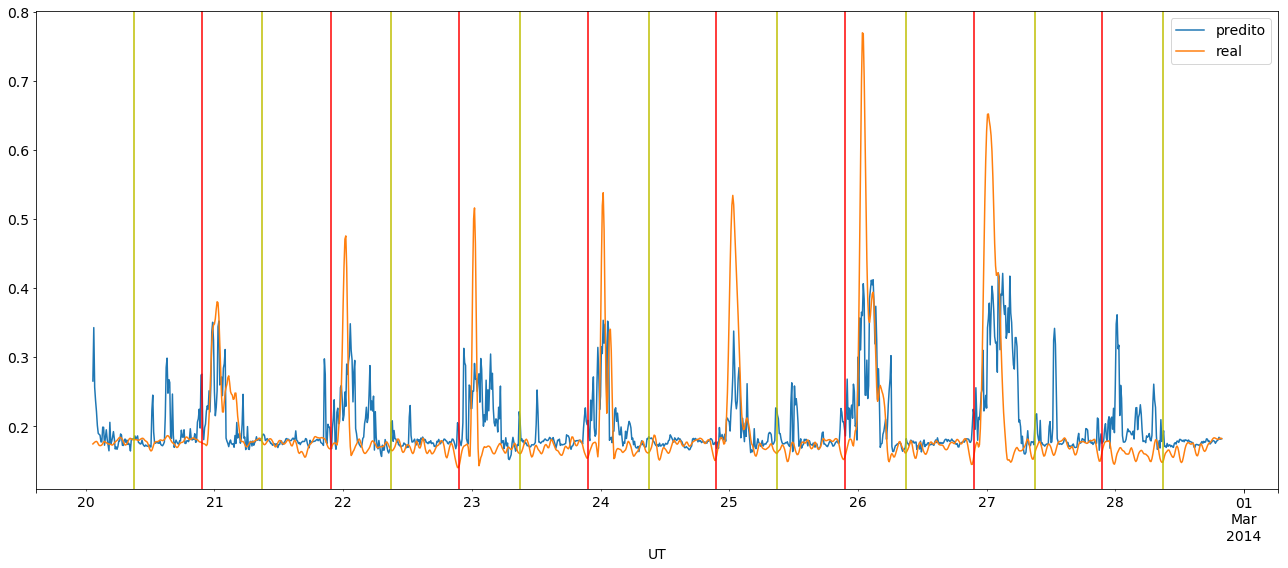

In [6]:
generate_and_avaliate_model(df, original, 's4')

O erro quadrático médio foi: 0.001232
O erro quadrático total foi: 2.050721
O maior erro por previsão foi: 0.274892
O erro relativo foi: 8.599002%
O número de verdadeiros negativos foi: 2764
O número de verdadeiros positivos foi: 255
O número de falsos negativos foi: 120
O número de falsos positivos foi: 275
O POD foi: 0.680000
O FAR foi: 0.518868
A ACC foi: 0.884300
O kappa foi: 0.034474

Error for the time series sample:
O erro quadrático médio foi: 0.004593
O erro quadrático total foi: 2.409410
O maior erro por previsão foi: 0.478619
O erro relativo foi: 18.167325%
O número de verdadeiros negativos foi: 820
O número de verdadeiros positivos foi: 125
O número de falsos negativos foi: 28
O número de falsos positivos foi: 291
O POD foi: 0.816993
O FAR foi: 0.699519
A ACC foi: 0.747627
O kappa foi: 0.037138


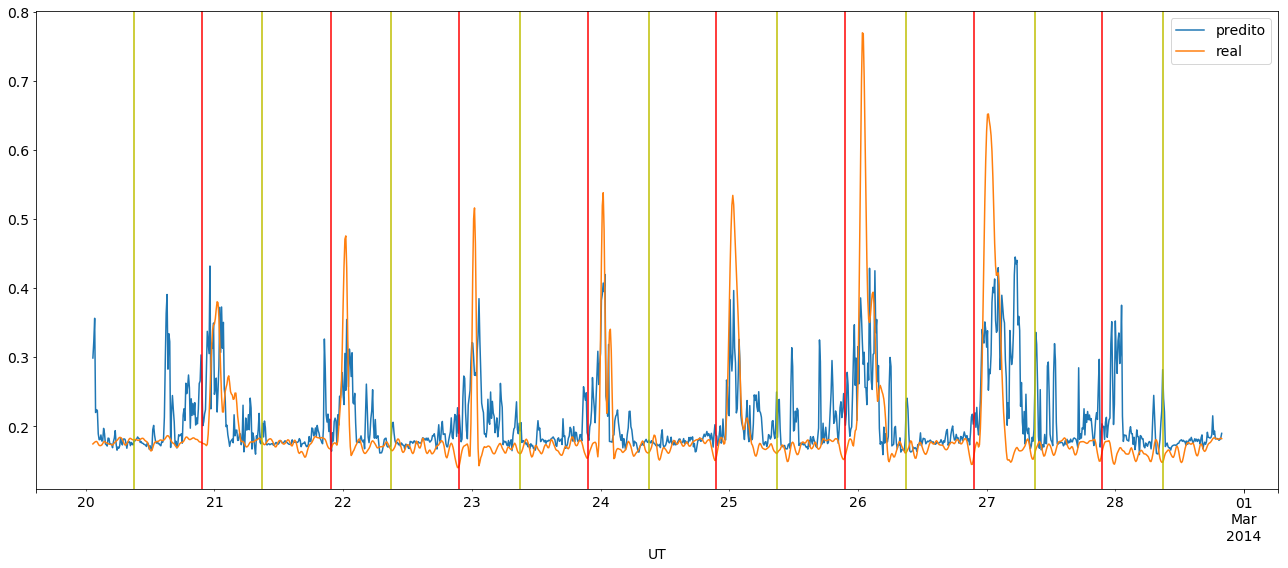

In [7]:
generate_and_avaliate_model(df, ['vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001030
O erro quadrático total foi: 1.874947
O maior erro por previsão foi: 0.306276
O erro relativo foi: 7.650678%
O número de verdadeiros negativos foi: 2790
O número de verdadeiros positivos foi: 291
O número de falsos negativos foi: 84
O número de falsos positivos foi: 249
O POD foi: 0.776000
O FAR foi: 0.461111
A ACC foi: 0.902460
O kappa foi: 0.026324

Error for the time series sample:
O erro quadrático médio foi: 0.003956
O erro quadrático total foi: 2.236026
O maior erro por previsão foi: 0.412250
O erro relativo foi: 14.709969%
O número de verdadeiros negativos foi: 912
O número de verdadeiros positivos foi: 128
O número de falsos negativos foi: 25
O número de falsos positivos foi: 199
O POD foi: 0.836601
O FAR foi: 0.608563
A ACC foi: 0.822785
O kappa foi: 0.030214


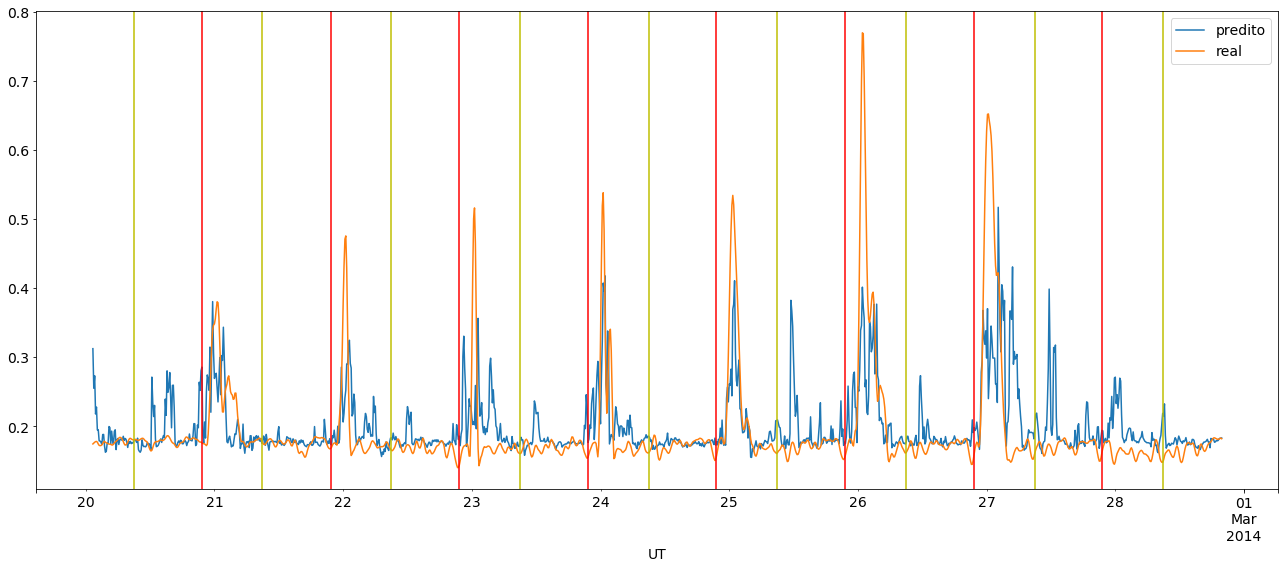

In [8]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.000954
O erro quadrático total foi: 1.805079
O maior erro por previsão foi: 0.323785
O erro relativo foi: 7.136090%
O número de verdadeiros negativos foi: 2761
O número de verdadeiros positivos foi: 315
O número de falsos negativos foi: 60
O número de falsos positivos foi: 278
O POD foi: 0.840000
O FAR foi: 0.468803
A ACC foi: 0.900996
O kappa foi: 0.021726

Error for the time series sample:
O erro quadrático médio foi: 0.003950
O erro quadrático total foi: 2.234573
O maior erro por previsão foi: 0.442784
O erro relativo foi: 14.516422%
O número de verdadeiros negativos foi: 882
O número de verdadeiros positivos foi: 122
O número de falsos negativos foi: 31
O número de falsos positivos foi: 229
O POD foi: 0.797386
O FAR foi: 0.652422
A ACC foi: 0.794304
O kappa foi: 0.034600


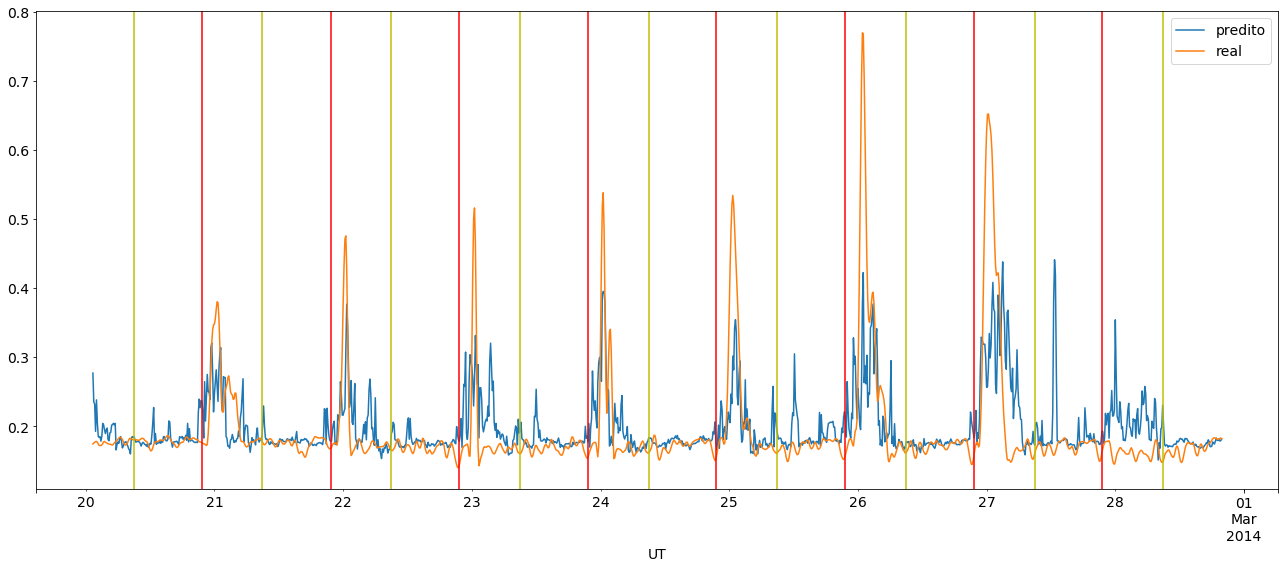

In [9]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001029
O erro quadrático total foi: 1.873883
O maior erro por previsão foi: 0.362620
O erro relativo foi: 7.377248%
O número de verdadeiros negativos foi: 2790
O número de verdadeiros positivos foi: 295
O número de falsos negativos foi: 80
O número de falsos positivos foi: 249
O POD foi: 0.786667
O FAR foi: 0.457721
A ACC foi: 0.903632
O kappa foi: 0.025452

Error for the time series sample:
O erro quadrático médio foi: 0.004359
O erro quadrático total foi: 2.347421
O maior erro por previsão foi: 0.393225
O erro relativo foi: 15.197290%
O número de verdadeiros negativos foi: 901
O número de verdadeiros positivos foi: 118
O número de falsos negativos foi: 35
O número de falsos positivos foi: 210
O POD foi: 0.771242
O FAR foi: 0.640244
A ACC foi: 0.806171
O kappa foi: 0.035248


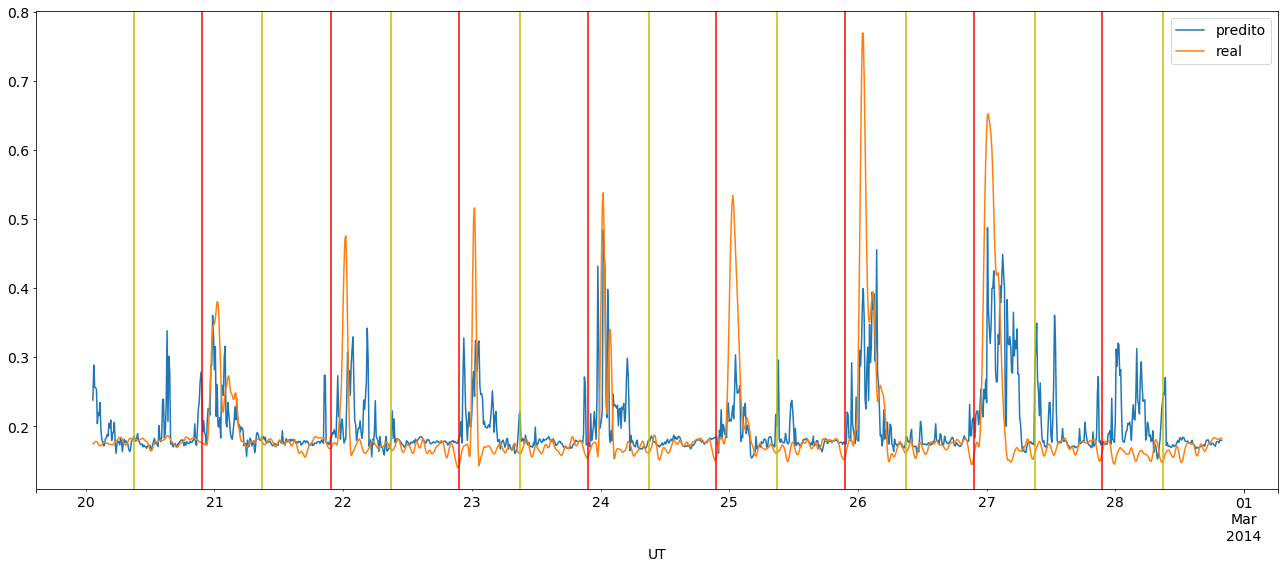

In [10]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001053
O erro quadrático total foi: 1.896302
O maior erro por previsão foi: 0.315640
O erro relativo foi: 7.304498%
O número de verdadeiros negativos foi: 2800
O número de verdadeiros positivos foi: 296
O número de falsos negativos foi: 79
O número de falsos positivos foi: 239
O POD foi: 0.789333
O FAR foi: 0.446729
A ACC foi: 0.906854
O kappa foi: 0.025048

Error for the time series sample:
O erro quadrático médio foi: 0.004659
O erro quadrático total foi: 2.426728
O maior erro por previsão foi: 0.514057
O erro relativo foi: 14.548635%
O número de verdadeiros negativos foi: 932
O número de verdadeiros positivos foi: 122
O número de falsos negativos foi: 31
O número de falsos positivos foi: 179
O POD foi: 0.797386
O FAR foi: 0.594684
A ACC foi: 0.833861
O kappa foi: 0.031752


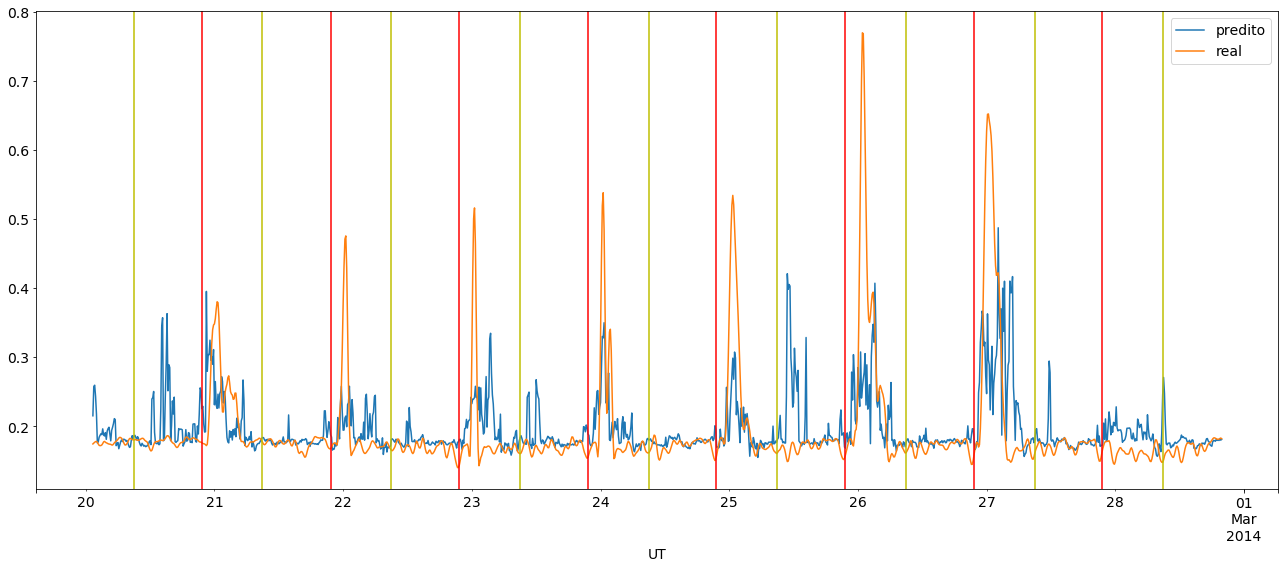

In [11]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001215
O erro quadrático total foi: 2.036789
O maior erro por previsão foi: 0.369818
O erro relativo foi: 8.045877%
O número de verdadeiros negativos foi: 2766
O número de verdadeiros positivos foi: 291
O número de falsos negativos foi: 84
O número de falsos positivos foi: 273
O POD foi: 0.776000
O FAR foi: 0.484043
A ACC foi: 0.895431
O kappa foi: 0.026750

Error for the time series sample:
O erro quadrático médio foi: 0.004547
O erro quadrático total foi: 2.397507
O maior erro por previsão foi: 0.429167
O erro relativo foi: 16.414242%
O número de verdadeiros negativos foi: 842
O número de verdadeiros positivos foi: 134
O número de falsos negativos foi: 19
O número de falsos positivos foi: 269
O POD foi: 0.875817
O FAR foi: 0.667494
A ACC foi: 0.772152
O kappa foi: 0.032574


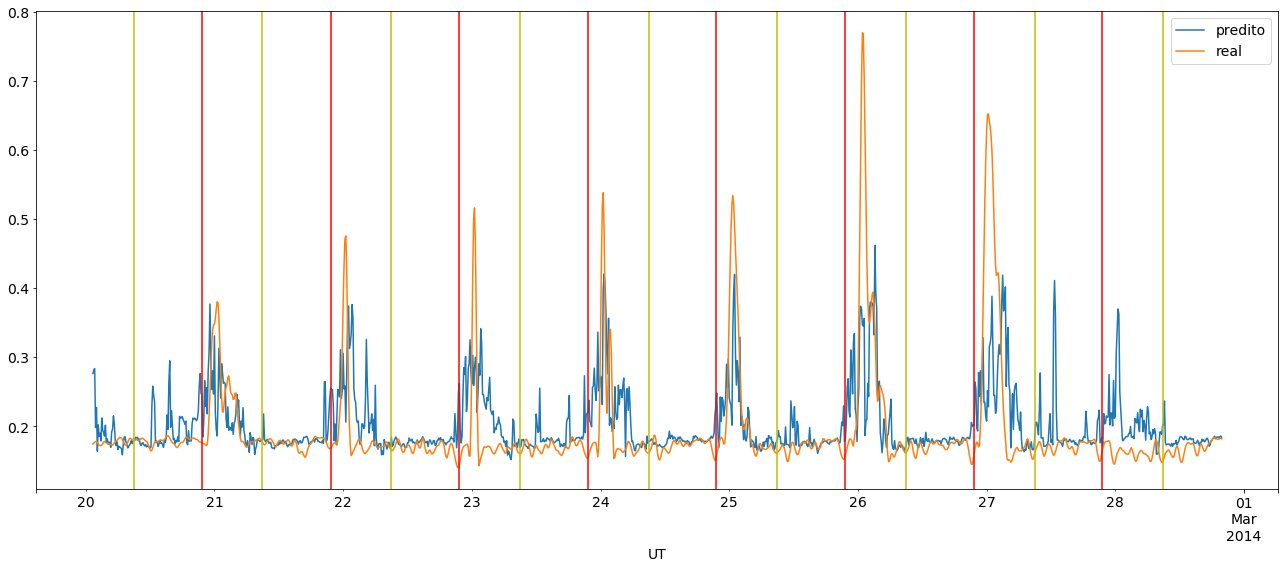

In [12]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001063
O erro quadrático total foi: 1.904941
O maior erro por previsão foi: 0.374028
O erro relativo foi: 7.366525%
O número de verdadeiros negativos foi: 2814
O número de verdadeiros positivos foi: 297
O número de falsos negativos foi: 78
O número de falsos positivos foi: 225
O POD foi: 0.792000
O FAR foi: 0.431034
A ACC foi: 0.911248
O kappa foi: 0.024565

Error for the time series sample:
O erro quadrático médio foi: 0.004409
O erro quadrático total foi: 2.360764
O maior erro por previsão foi: 0.543885
O erro relativo foi: 14.177826%
O número de verdadeiros negativos foi: 925
O número de verdadeiros positivos foi: 132
O número de falsos negativos foi: 21
O número de falsos positivos foi: 186
O POD foi: 0.862745
O FAR foi: 0.584906
A ACC foi: 0.836234
O kappa foi: 0.027525


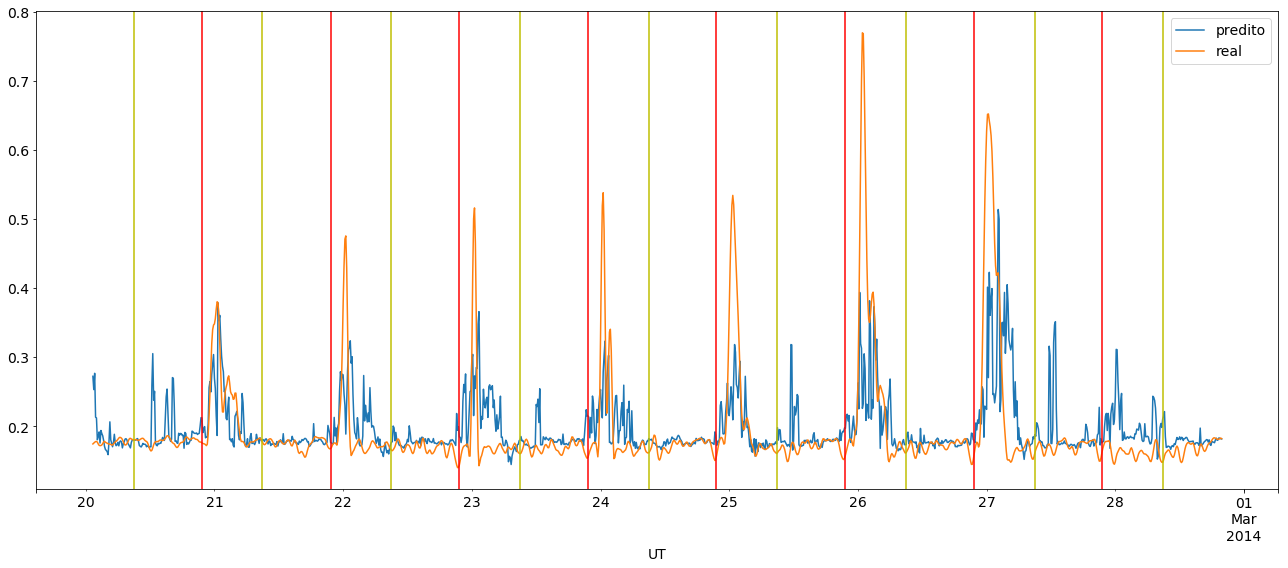

In [13]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2'], 's4')

O erro quadrático médio foi: 0.002861
O erro quadrático total foi: 3.125541
O maior erro por previsão foi: 0.413468
O erro relativo foi: 12.805589%
O número de verdadeiros negativos foi: 2629
O número de verdadeiros positivos foi: 129
O número de falsos negativos foi: 246
O número de falsos positivos foi: 410
O POD foi: 0.344000
O FAR foi: 0.760668
A ACC foi: 0.807850
O kappa foi: 0.060026

Error for the time series sample:
O erro quadrático médio foi: 0.006565
O erro quadrático total foi: 2.880675
O maior erro por previsão foi: 0.590341
O erro relativo foi: 14.891384%
O número de verdadeiros negativos foi: 979
O número de verdadeiros positivos foi: 44
O número de falsos negativos foi: 109
O número de falsos positivos foi: 132
O POD foi: 0.287582
O FAR foi: 0.750000
A ACC foi: 0.809335
O kappa foi: 0.070426


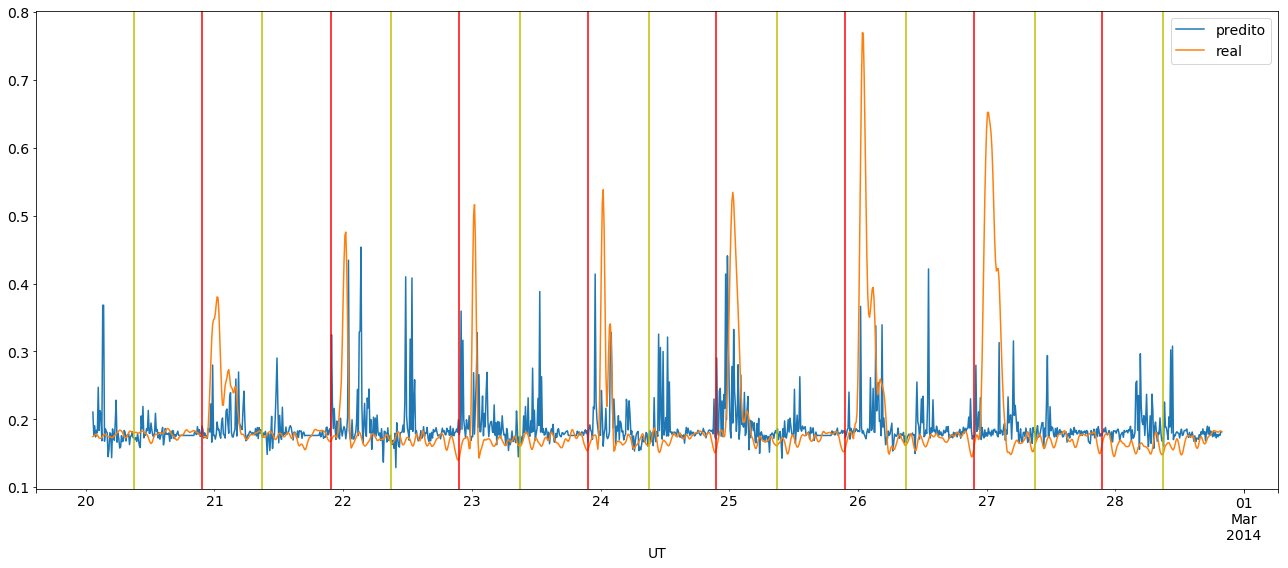

In [14]:
generate_and_avaliate_model(df, ['vtec',], 's4')

O erro quadrático médio foi: 0.001693
O erro quadrático total foi: 2.403856
O maior erro por previsão foi: 0.374737
O erro relativo foi: 9.558833%
O número de verdadeiros negativos foi: 2703
O número de verdadeiros positivos foi: 248
O número de falsos negativos foi: 127
O número de falsos positivos foi: 336
O POD foi: 0.661333
O FAR foi: 0.575342
A ACC foi: 0.864382
O kappa foi: 0.036602

Error for the time series sample:
O erro quadrático médio foi: 0.005118
O erro quadrático total foi: 2.543516
O maior erro por previsão foi: 0.521751
O erro relativo foi: 14.897003%
O número de verdadeiros negativos foi: 944
O número de verdadeiros positivos foi: 103
O número de falsos negativos foi: 50
O número de falsos positivos foi: 167
O POD foi: 0.673203
O FAR foi: 0.618519
A ACC foi: 0.828323
O kappa foi: 0.040309


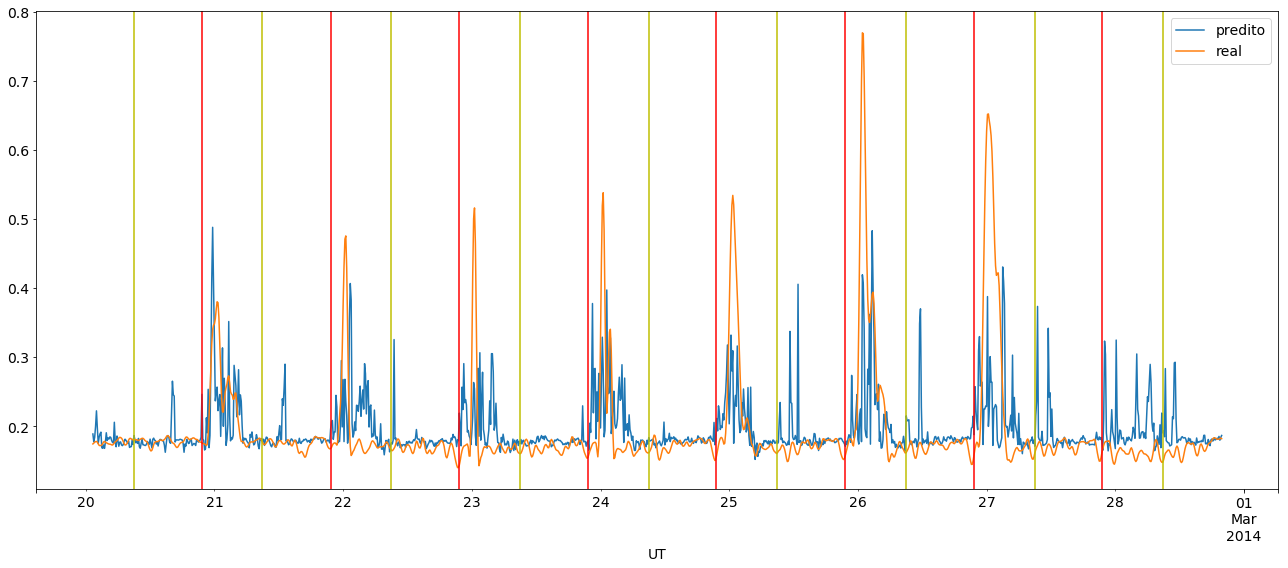

In [15]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt', 'vtec_dt2'], 's4')

O erro quadrático médio foi: 0.001510
O erro quadrático total foi: 2.270428
O maior erro por previsão foi: 0.391248
O erro relativo foi: 9.115393%
O número de verdadeiros negativos foi: 2730
O número de verdadeiros positivos foi: 262
O número de falsos negativos foi: 113
O número de falsos positivos foi: 309
O POD foi: 0.698667
O FAR foi: 0.541156
A ACC foi: 0.876391
O kappa foi: 0.033414

Error for the time series sample:
O erro quadrático médio foi: 0.005680
O erro quadrático total foi: 2.679485
O maior erro por previsão foi: 0.551061
O erro relativo foi: 14.825462%
O número de verdadeiros negativos foi: 945
O número de verdadeiros positivos foi: 94
O número de falsos negativos foi: 59
O número de falsos positivos foi: 166
O POD foi: 0.614379
O FAR foi: 0.638462
A ACC foi: 0.821994
O kappa foi: 0.044664


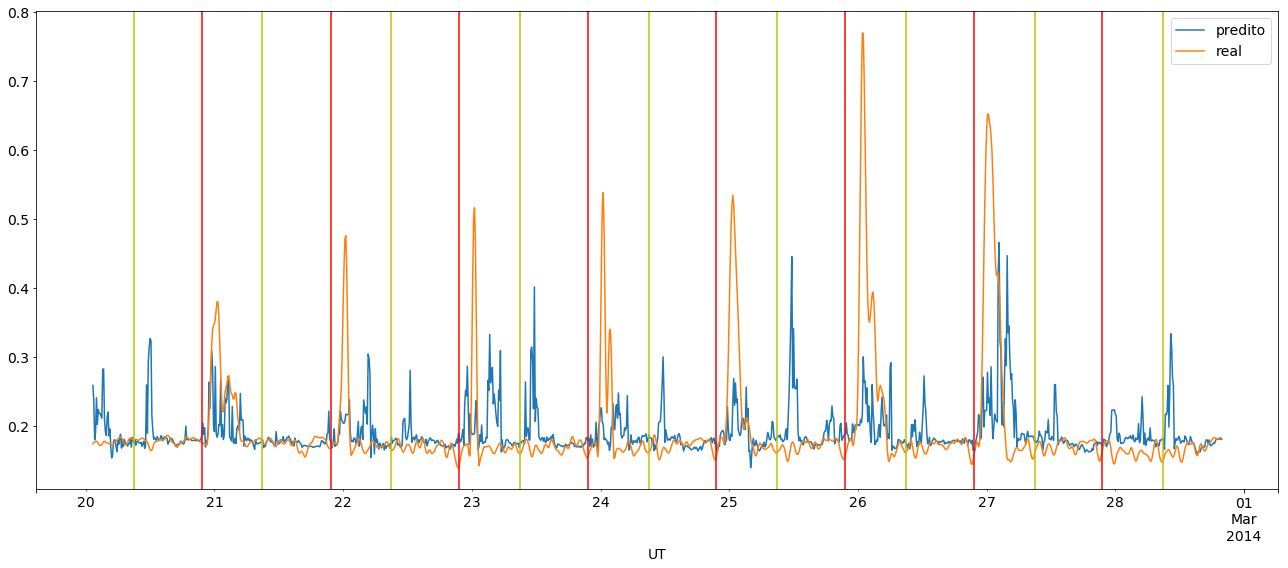

In [16]:
generate_and_avaliate_model(df, ['vtec', 'gvtec1', 'gvtec2'], 's4')

O erro quadrático médio foi: 0.001221
O erro quadrático total foi: 2.041404
O maior erro por previsão foi: 0.328732
O erro relativo foi: 8.066805%
O número de verdadeiros negativos foi: 2757
O número de verdadeiros positivos foi: 285
O número de falsos negativos foi: 90
O número de falsos positivos foi: 282
O POD foi: 0.760000
O FAR foi: 0.497354
A ACC foi: 0.891037
O kappa foi: 0.028184

Error for the time series sample:
O erro quadrático médio foi: 0.004457
O erro quadrático total foi: 2.373635
O maior erro por previsão foi: 0.480024
O erro relativo foi: 15.865272%
O número de verdadeiros negativos foi: 877
O número de verdadeiros positivos foi: 135
O número de falsos negativos foi: 18
O número de falsos positivos foi: 234
O POD foi: 0.882353
O FAR foi: 0.634146
A ACC foi: 0.800633
O kappa foi: 0.029653


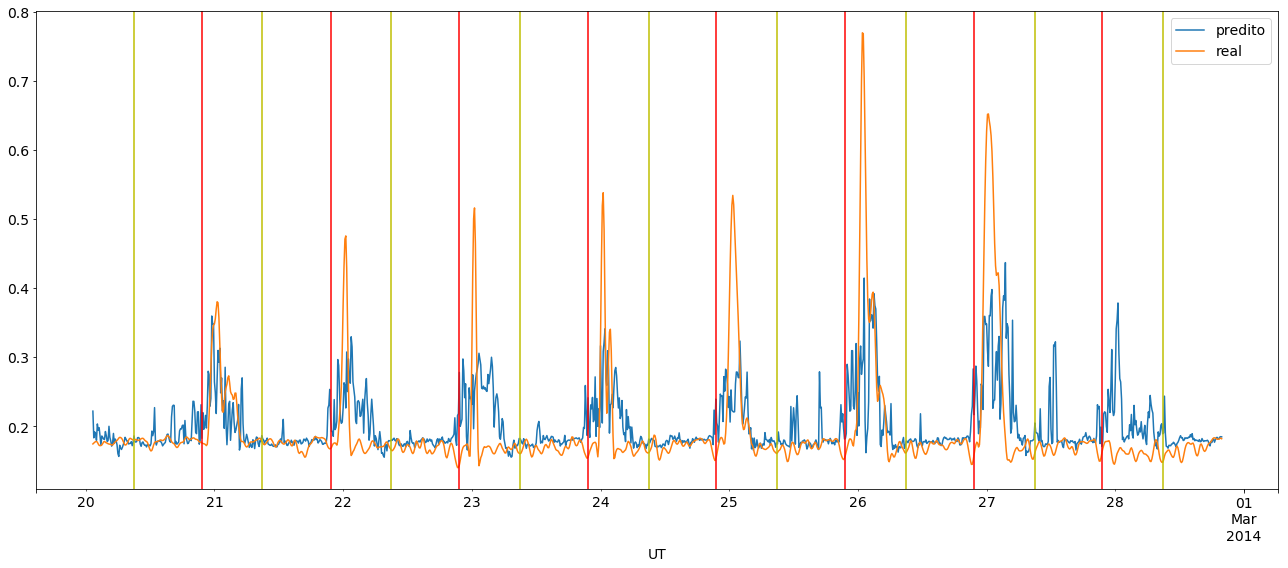

In [17]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt'], 's4')

O erro quadrático médio foi: 0.000832
O erro quadrático total foi: 1.685454
O maior erro por previsão foi: 0.298625
O erro relativo foi: 6.666310%
O número de verdadeiros negativos foi: 2843
O número de verdadeiros positivos foi: 314
O número de falsos negativos foi: 61
O número de falsos positivos foi: 196
O POD foi: 0.837333
O FAR foi: 0.384314
A ACC foi: 0.924722
O kappa foi: 0.020160

Error for the time series sample:
O erro quadrático médio foi: 0.003931
O erro quadrático total foi: 2.229166
O maior erro por previsão foi: 0.464760
O erro relativo foi: 15.446654%
O número de verdadeiros negativos foi: 857
O número de verdadeiros positivos foi: 133
O número de falsos negativos foi: 20
O número de falsos positivos foi: 254
O POD foi: 0.869281
O FAR foi: 0.656331
A ACC foi: 0.783228
O kappa foi: 0.031872


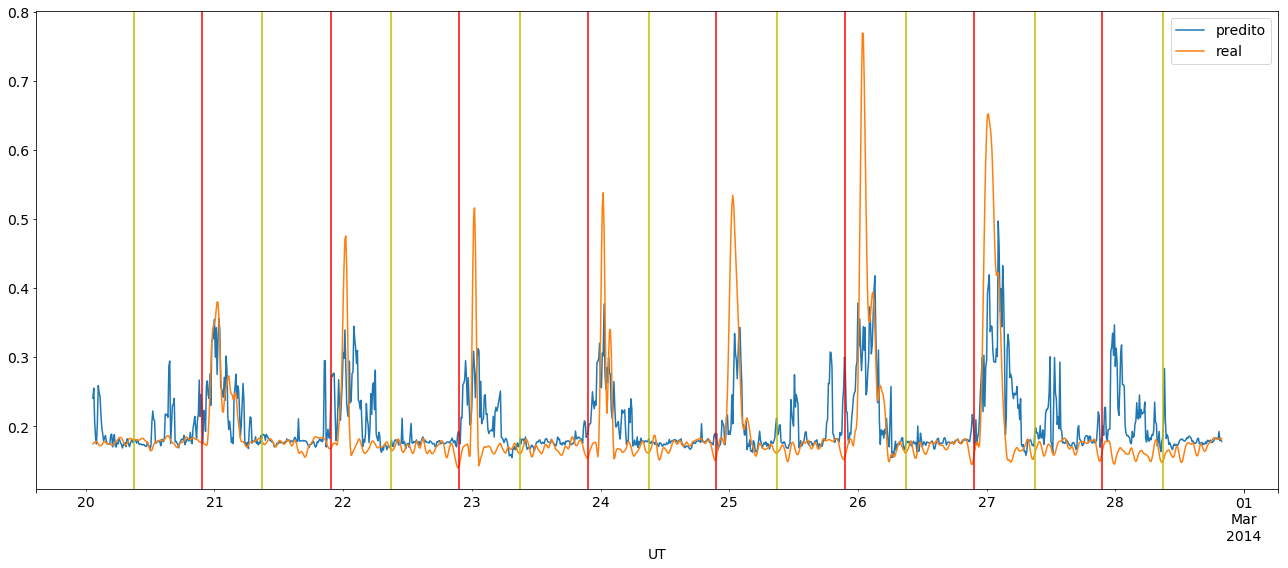

In [18]:
generate_and_avaliate_model(df, original + lag, 's4')

O erro quadrático médio foi: 0.001009
O erro quadrático total foi: 1.855800
O maior erro por previsão foi: 0.327148
O erro relativo foi: 7.081638%
O número de verdadeiros negativos foi: 2824
O número de verdadeiros positivos foi: 312
O número de falsos negativos foi: 63
O número de falsos positivos foi: 215
O POD foi: 0.832000
O FAR foi: 0.407970
A ACC foi: 0.918571
O kappa foi: 0.021020

Error for the time series sample:
O erro quadrático médio foi: 0.003905
O erro quadrático total foi: 2.221615
O maior erro por previsão foi: 0.506653
O erro relativo foi: 14.618895%
O número de verdadeiros negativos foi: 908
O número de verdadeiros positivos foi: 137
O número de falsos negativos foi: 16
O número de falsos positivos foi: 203
O POD foi: 0.895425
O FAR foi: 0.597059
A ACC foi: 0.826741
O kappa foi: 0.026500


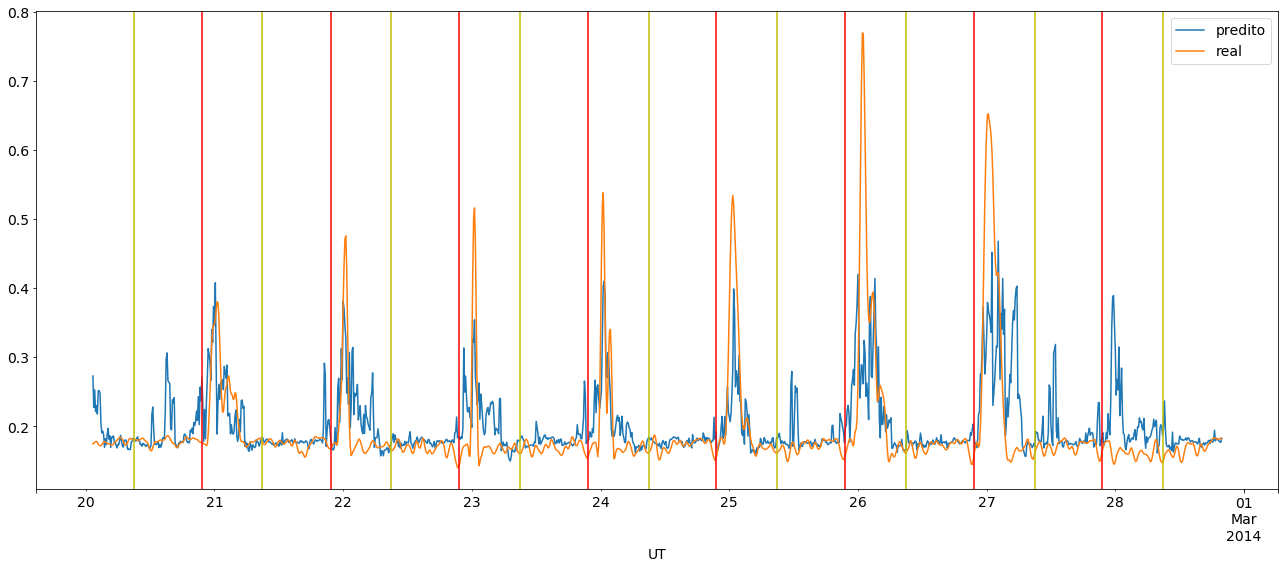

In [19]:
generate_and_avaliate_model(df, original + ['gvtec1_dt_lag_9',], 's4')

O erro quadrático médio foi: 0.000813
O erro quadrático total foi: 1.666182
O maior erro por previsão foi: 0.333121
O erro relativo foi: 6.577406%
O número de verdadeiros negativos foi: 2846
O número de verdadeiros positivos foi: 296
O número de falsos negativos foi: 79
O número de falsos positivos foi: 193
O POD foi: 0.789333
O FAR foi: 0.394683
A ACC foi: 0.920328
O kappa foi: 0.024192

Error for the time series sample:
O erro quadrático médio foi: 0.004057
O erro quadrático total foi: 2.264431
O maior erro por previsão foi: 0.527128
O erro relativo foi: 14.776777%
O número de verdadeiros negativos foi: 885
O número de verdadeiros positivos foi: 131
O número de falsos negativos foi: 22
O número de falsos positivos foi: 226
O POD foi: 0.856209
O FAR foi: 0.633053
A ACC foi: 0.803797
O kappa foi: 0.030717


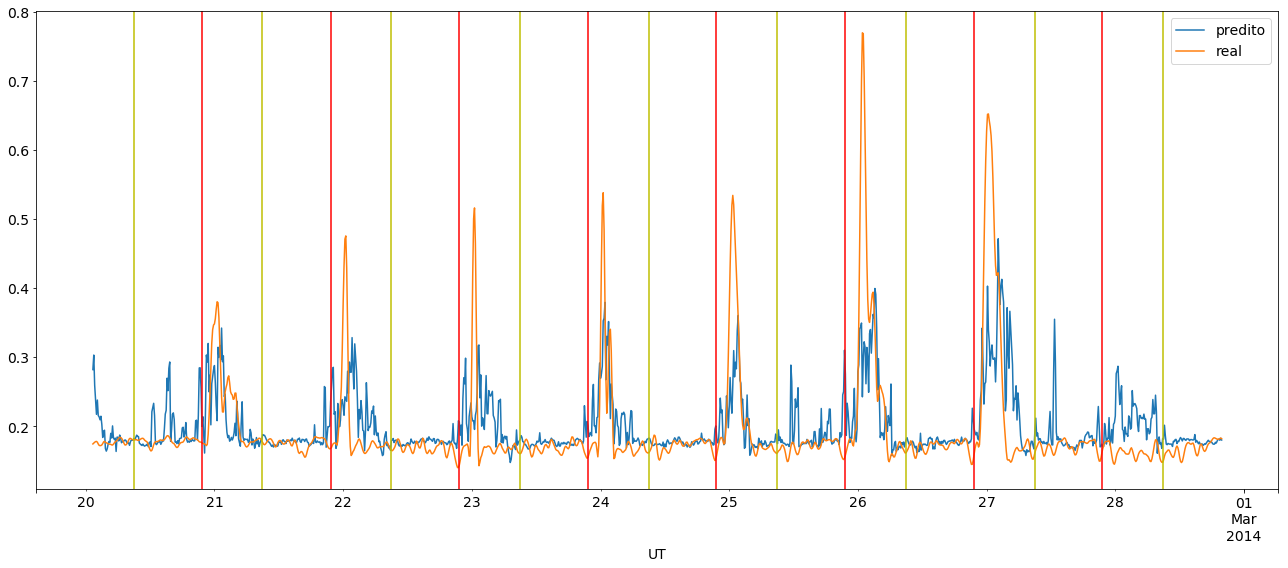

In [20]:
generate_and_avaliate_model(df, original + ['gvtec2_dt_lag_20',], 's4')

O erro quadrático médio foi: 0.000802
O erro quadrático total foi: 1.654990
O maior erro por previsão foi: 0.276036
O erro relativo foi: 6.027260%
O número de verdadeiros negativos foi: 2845
O número de verdadeiros positivos foi: 308
O número de falsos negativos foi: 67
O número de falsos positivos foi: 194
O POD foi: 0.821333
O FAR foi: 0.386454
A ACC foi: 0.923550
O kappa foi: 0.021481

Error for the time series sample:
O erro quadrático médio foi: 0.004293
O erro quadrático total foi: 2.329488
O maior erro por previsão foi: 0.480337
O erro relativo foi: 14.525736%
O número de verdadeiros negativos foi: 919
O número de verdadeiros positivos foi: 116
O número de falsos negativos foi: 37
O número de falsos positivos foi: 192
O POD foi: 0.758170
O FAR foi: 0.623377
A ACC foi: 0.818829
O kappa foi: 0.035223


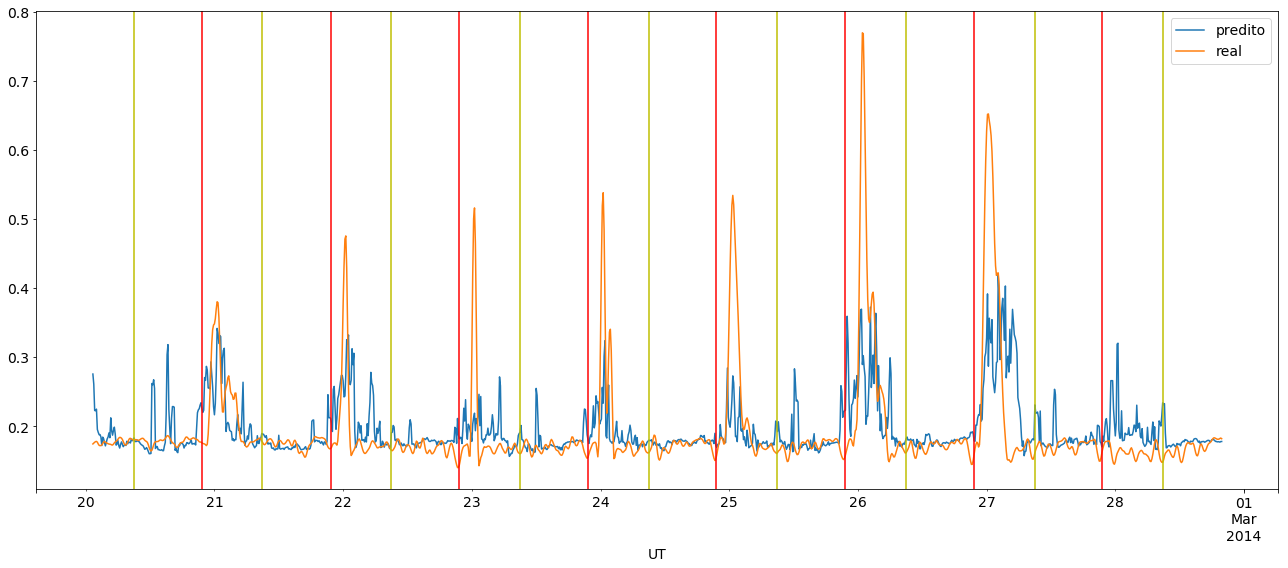

In [21]:
generate_and_avaliate_model(df, original + mdv1, 's4')

O erro quadrático médio foi: 0.000735
O erro quadrático total foi: 1.584523
O maior erro por previsão foi: 0.275244
O erro relativo foi: 5.864884%
O número de verdadeiros negativos foi: 2875
O número de verdadeiros positivos foi: 310
O número de falsos negativos foi: 65
O número de falsos positivos foi: 164
O POD foi: 0.826667
O FAR foi: 0.345992
A ACC foi: 0.932923
O kappa foi: 0.020395

Error for the time series sample:
O erro quadrático médio foi: 0.004690
O erro quadrático total foi: 2.434795
O maior erro por previsão foi: 0.536163
O erro relativo foi: 14.112360%
O número de verdadeiros negativos foi: 918
O número de verdadeiros positivos foi: 112
O número de falsos negativos foi: 41
O número de falsos positivos foi: 193
O POD foi: 0.732026
O FAR foi: 0.632787
A ACC foi: 0.814873
O kappa foi: 0.037087


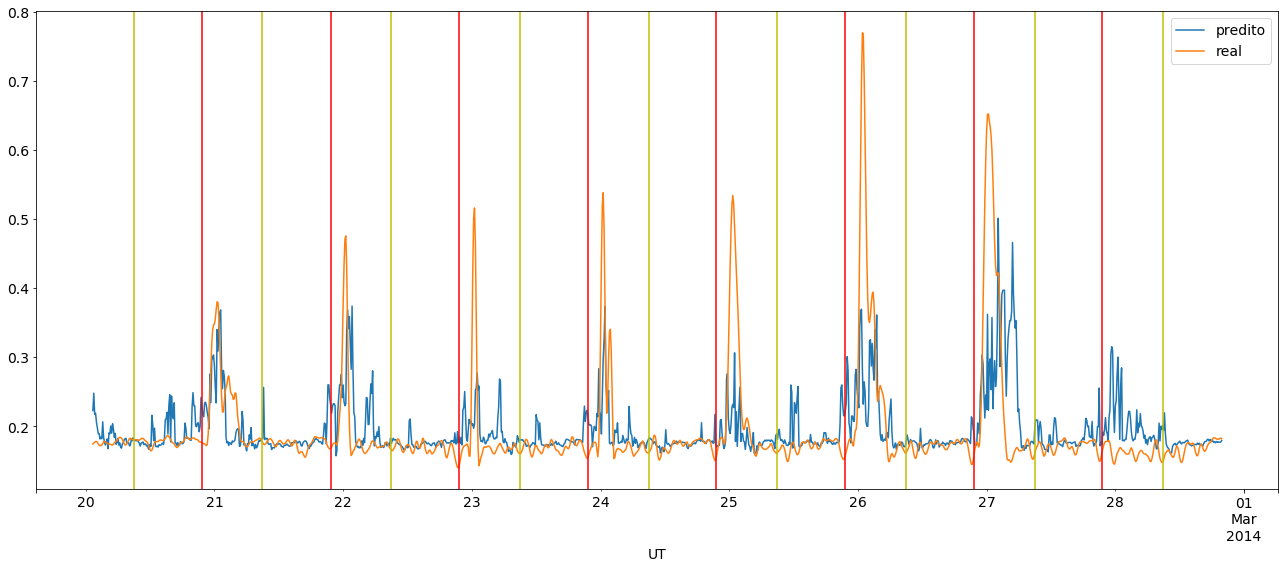

In [22]:
generate_and_avaliate_model(df, original + mdv2, 's4')

O erro quadrático médio foi: 0.000792
O erro quadrático total foi: 1.644194
O maior erro por previsão foi: 0.266737
O erro relativo foi: 6.349186%
O número de verdadeiros negativos foi: 2861
O número de verdadeiros positivos foi: 310
O número de falsos negativos foi: 65
O número de falsos positivos foi: 178
O POD foi: 0.826667
O FAR foi: 0.364754
A ACC foi: 0.928822
O kappa foi: 0.020690

Error for the time series sample:
O erro quadrático médio foi: 0.003535
O erro quadrático total foi: 2.113811
O maior erro por previsão foi: 0.512395
O erro relativo foi: 14.133346%
O número de verdadeiros negativos foi: 914
O número de verdadeiros positivos foi: 132
O número de falsos negativos foi: 21
O número de falsos positivos foi: 197
O POD foi: 0.862745
O FAR foi: 0.598784
A ACC foi: 0.827532
O kappa foi: 0.028289


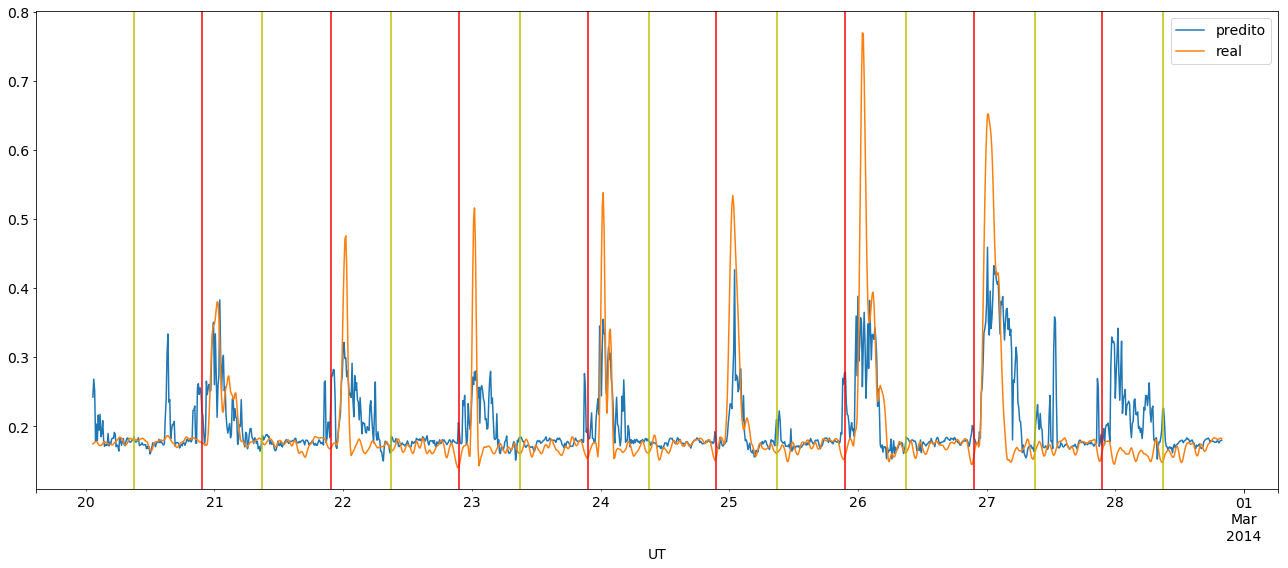

In [23]:
generate_and_avaliate_model(df, original + tempo + lag, 's4')

O erro quadrático médio foi: 0.000562
O erro quadrático total foi: 1.385347
O maior erro por previsão foi: 0.213921
O erro relativo foi: 5.223241%
O número de verdadeiros negativos foi: 2905
O número de verdadeiros positivos foi: 317
O número de falsos negativos foi: 58
O número de falsos positivos foi: 134
O POD foi: 0.845333
O FAR foi: 0.297118
A ACC foi: 0.943761
O kappa foi: 0.018100

Error for the time series sample:
O erro quadrático médio foi: 0.004067
O erro quadrático total foi: 2.267376
O maior erro por previsão foi: 0.430584
O erro relativo foi: 13.326323%
O número de verdadeiros negativos foi: 942
O número de verdadeiros positivos foi: 116
O número de falsos negativos foi: 37
O número de falsos positivos foi: 169
O POD foi: 0.758170
O FAR foi: 0.592982
A ACC foi: 0.837025
O kappa foi: 0.034085


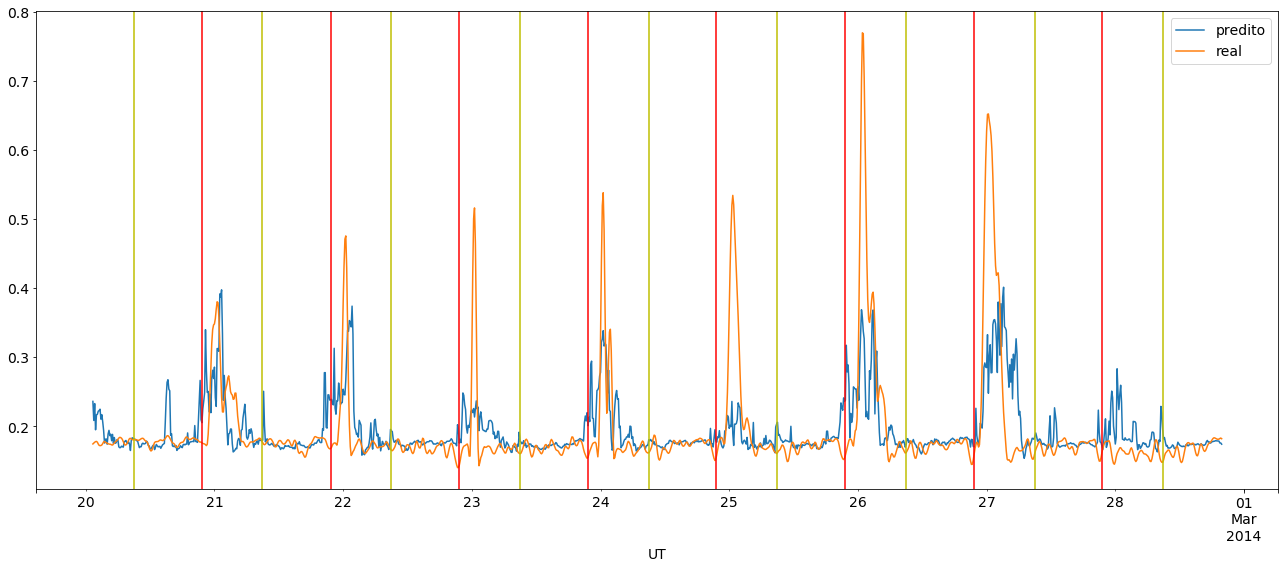

In [24]:
generate_and_avaliate_model(df, original + tempo + mdv2, 's4')

O erro quadrático médio foi: 0.000588
O erro quadrático total foi: 1.417163
O maior erro por previsão foi: 0.284242
O erro relativo foi: 5.292458%
O número de verdadeiros negativos foi: 2899
O número de verdadeiros positivos foi: 317
O número de falsos negativos foi: 58
O número de falsos positivos foi: 140
O POD foi: 0.845333
O FAR foi: 0.306346
A ACC foi: 0.942004
O kappa foi: 0.018234

Error for the time series sample:
O erro quadrático médio foi: 0.004160
O erro quadrático total foi: 2.293181
O maior erro por previsão foi: 0.514738
O erro relativo foi: 12.938220%
O número de verdadeiros negativos foi: 928
O número de verdadeiros positivos foi: 120
O número de falsos negativos foi: 33
O número de falsos positivos foi: 183
O POD foi: 0.784314
O FAR foi: 0.603960
A ACC foi: 0.829114
O kappa foi: 0.032912


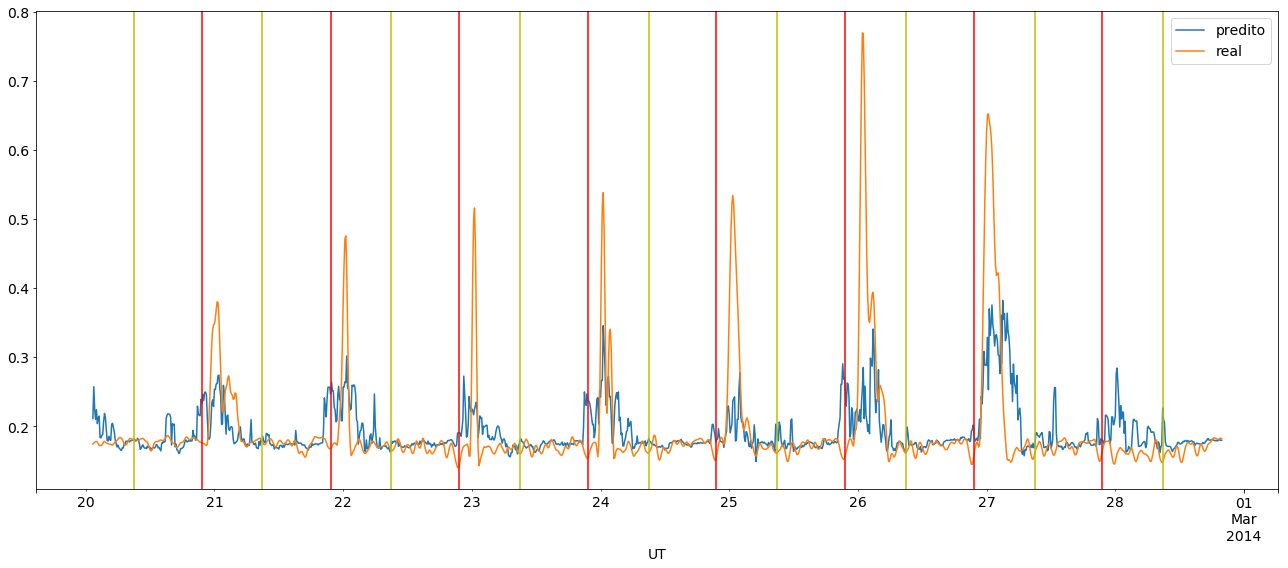

In [25]:
generate_and_avaliate_model(df, original + tempo + mdv2 + lag, 's4')

O erro quadrático médio foi: 0.001643
O erro quadrático total foi: 2.368479
O maior erro por previsão foi: 0.405306
O erro relativo foi: 9.803545%
O número de verdadeiros negativos foi: 2677
O número de verdadeiros positivos foi: 199
O número de falsos negativos foi: 176
O número de falsos positivos foi: 362
O POD foi: 0.530667
O FAR foi: 0.645276
A ACC foi: 0.842414
O kappa foi: 0.046604

Error for the time series sample:
O erro quadrático médio foi: 0.003962
O erro quadrático total foi: 2.237924
O maior erro por previsão foi: 0.466107
O erro relativo foi: 16.107914%
O número de verdadeiros negativos foi: 897
O número de verdadeiros positivos foi: 112
O número de falsos negativos foi: 41
O número de falsos positivos foi: 214
O POD foi: 0.732026
O FAR foi: 0.656442
A ACC foi: 0.798259
O kappa foi: 0.038020


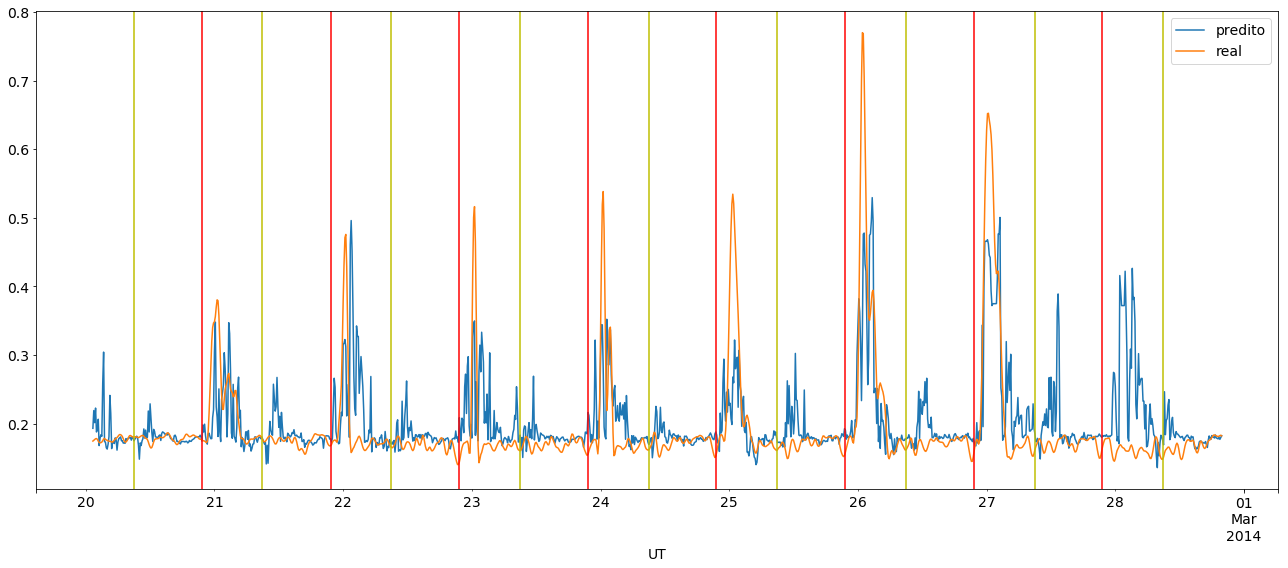

In [26]:
generate_and_avaliate_model(df, ['vtec',] + lag, 's4')

O erro quadrático médio foi: 0.002056
O erro quadrático total foi: 2.649239
O maior erro por previsão foi: 0.400159
O erro relativo foi: 11.070319%
O número de verdadeiros negativos foi: 2632
O número de verdadeiros positivos foi: 168
O número de falsos negativos foi: 207
O número de falsos positivos foi: 407
O POD foi: 0.448000
O FAR foi: 0.707826
A ACC foi: 0.820152
O kappa foi: 0.052611

Error for the time series sample:
O erro quadrático médio foi: 0.004873
O erro quadrático total foi: 2.481926
O maior erro por previsão foi: 0.513309
O erro relativo foi: 17.149111%
O número de verdadeiros negativos foi: 894
O número de verdadeiros positivos foi: 109
O número de falsos negativos foi: 44
O número de falsos positivos foi: 217
O POD foi: 0.712418
O FAR foi: 0.665644
A ACC foi: 0.793513
O kappa foi: 0.039425


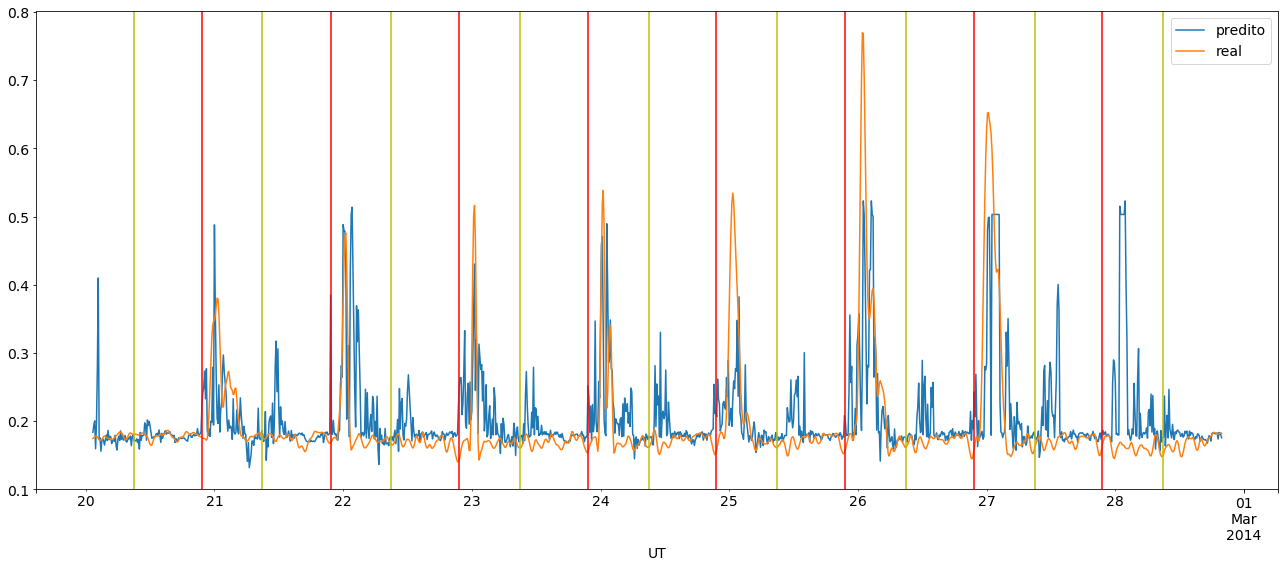

In [27]:
generate_and_avaliate_model(df, ['vtec', 'gvtec1_dt_lag_9'], 's4')

O erro quadrático médio foi: 0.001962
O erro quadrático total foi: 2.587783
O maior erro por previsão foi: 0.409105
O erro relativo foi: 10.612674%
O número de verdadeiros negativos foi: 2649
O número de verdadeiros positivos foi: 183
O número de falsos negativos foi: 192
O número de falsos positivos foi: 390
O POD foi: 0.488000
O FAR foi: 0.680628
A ACC foi: 0.829525
O kappa foi: 0.049760

Error for the time series sample:
O erro quadrático médio foi: 0.004220
O erro quadrático total foi: 2.309678
O maior erro por previsão foi: 0.443015
O erro relativo foi: 14.508810%
O número de verdadeiros negativos foi: 955
O número de verdadeiros positivos foi: 86
O número de falsos negativos foi: 67
O número de falsos positivos foi: 156
O POD foi: 0.562092
O FAR foi: 0.644628
A ACC foi: 0.823576
O kappa foi: 0.048445


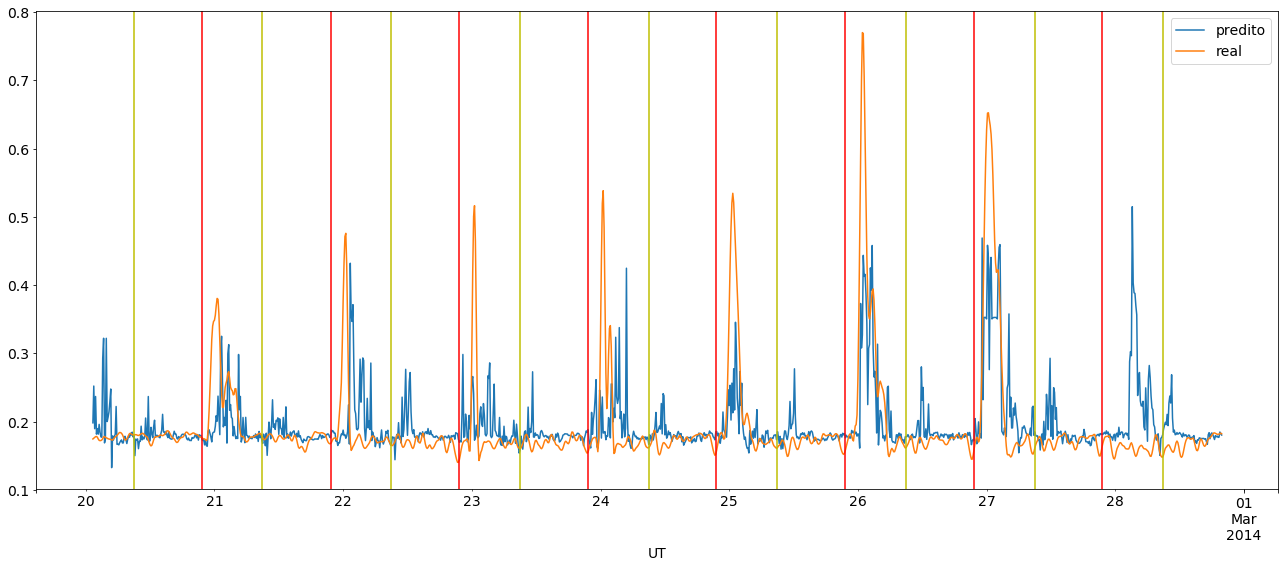

In [28]:
generate_and_avaliate_model(df, ['vtec', 'gvtec2_dt_lag_20'], 's4')

O erro quadrático médio foi: 0.002144
O erro quadrático total foi: 2.705403
O maior erro por previsão foi: 0.402702
O erro relativo foi: 10.414696%
O número de verdadeiros negativos foi: 2811
O número de verdadeiros positivos foi: 212
O número de falsos negativos foi: 163
O número de falsos positivos foi: 228
O POD foi: 0.565333
O FAR foi: 0.518182
A ACC foi: 0.885472
O kappa foi: 0.043459

Error for the time series sample:
O erro quadrático médio foi: 0.005524
O erro quadrático total foi: 2.642367
O maior erro por previsão foi: 0.492699
O erro relativo foi: 15.948233%
O número de verdadeiros negativos foi: 957
O número de verdadeiros positivos foi: 123
O número de falsos negativos foi: 30
O número de falsos positivos foi: 154
O POD foi: 0.803922
O FAR foi: 0.555957
A ACC foi: 0.854430
O kappa foi: 0.029825


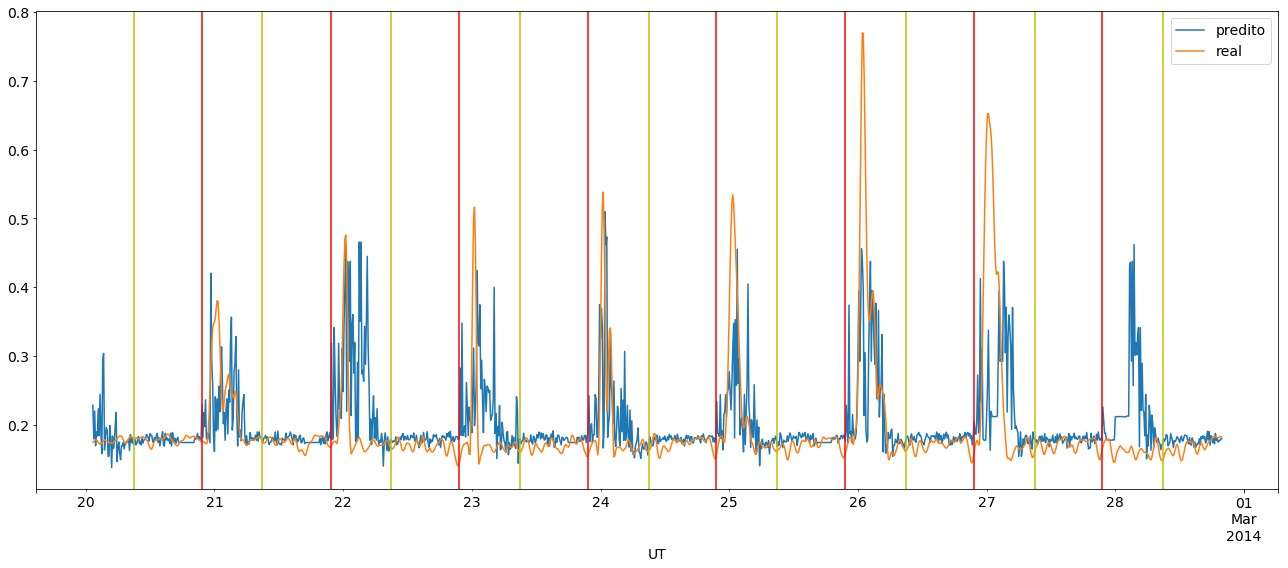

In [29]:
generate_and_avaliate_model(df, ['vtec',] + tempo, 's4')

O erro quadrático médio foi: 0.002167
O erro quadrático total foi: 2.719694
O maior erro por previsão foi: 0.400038
O erro relativo foi: 10.426420%
O número de verdadeiros negativos foi: 2814
O número de verdadeiros positivos foi: 210
O número de falsos negativos foi: 165
O número de falsos positivos foi: 225
O POD foi: 0.560000
O FAR foi: 0.517241
A ACC foi: 0.885764
O kappa foi: 0.043890

Error for the time series sample:
O erro quadrático médio foi: 0.005612
O erro quadrático total foi: 2.663327
O maior erro por previsão foi: 0.510055
O erro relativo foi: 15.961951%
O número de verdadeiros negativos foi: 960
O número de verdadeiros positivos foi: 119
O número de falsos negativos foi: 34
O número de falsos positivos foi: 151
O POD foi: 0.777778
O FAR foi: 0.559259
A ACC foi: 0.853639
O kappa foi: 0.031676


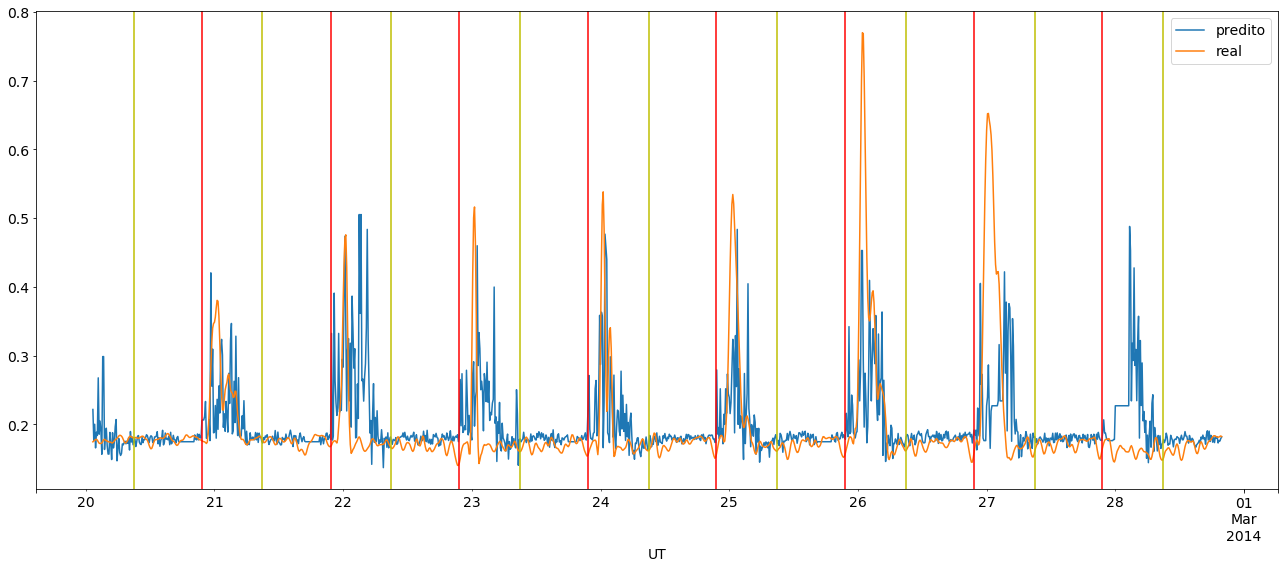

In [30]:
generate_and_avaliate_model(df, ['vtec',] + tempo, 's4')

O erro quadrático médio foi: 0.000965
O erro quadrático total foi: 1.815237
O maior erro por previsão foi: 0.371688
O erro relativo foi: 6.124519%
O número de verdadeiros negativos foi: 2886
O número de verdadeiros positivos foi: 304
O número de falsos negativos foi: 71
O número de falsos positivos foi: 153
O POD foi: 0.810667
O FAR foi: 0.334792
A ACC foi: 0.934388
O kappa foi: 0.021571

Error for the time series sample:
O erro quadrático médio foi: 0.005866
O erro quadrático total foi: 2.722911
O maior erro por previsão foi: 0.601144
O erro relativo foi: 14.051215%
O número de verdadeiros negativos foi: 1000
O número de verdadeiros positivos foi: 85
O número de falsos negativos foi: 68
O número de falsos positivos foi: 111
O POD foi: 0.555556
O FAR foi: 0.566327
A ACC foi: 0.858386
O kappa foi: 0.048467


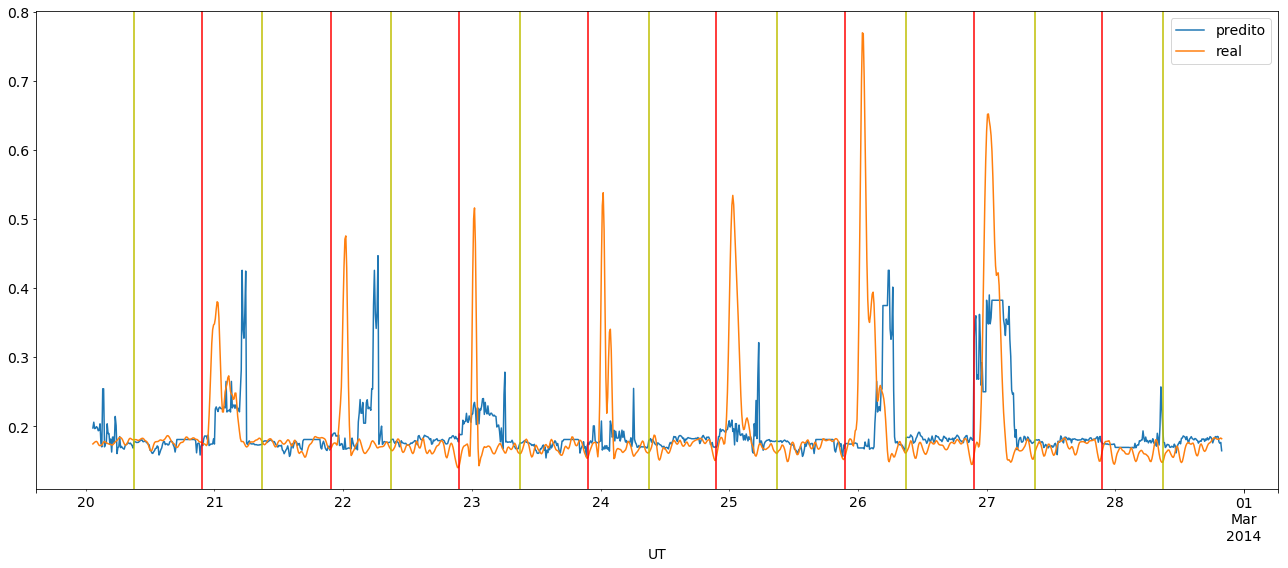

In [31]:
generate_and_avaliate_model(df, ['vtec',] + tempo + mdv1, 's4')

O erro quadrático médio foi: 0.000958
O erro quadrático total foi: 1.808693
O maior erro por previsão foi: 0.382606
O erro relativo foi: 6.128404%
O número de verdadeiros negativos foi: 2906
O número de verdadeiros positivos foi: 292
O número de falsos negativos foi: 83
O número de falsos positivos foi: 133
O POD foi: 0.778667
O FAR foi: 0.312941
A ACC foi: 0.936731
O kappa foi: 0.024026

Error for the time series sample:
O erro quadrático médio foi: 0.004558
O erro quadrático total foi: 2.400367
O maior erro por previsão foi: 0.479345
O erro relativo foi: 14.234462%
O número de verdadeiros negativos foi: 964
O número de verdadeiros positivos foi: 128
O número de falsos negativos foi: 25
O número de falsos positivos foi: 147
O POD foi: 0.836601
O FAR foi: 0.534545
A ACC foi: 0.863924
O kappa foi: 0.026861


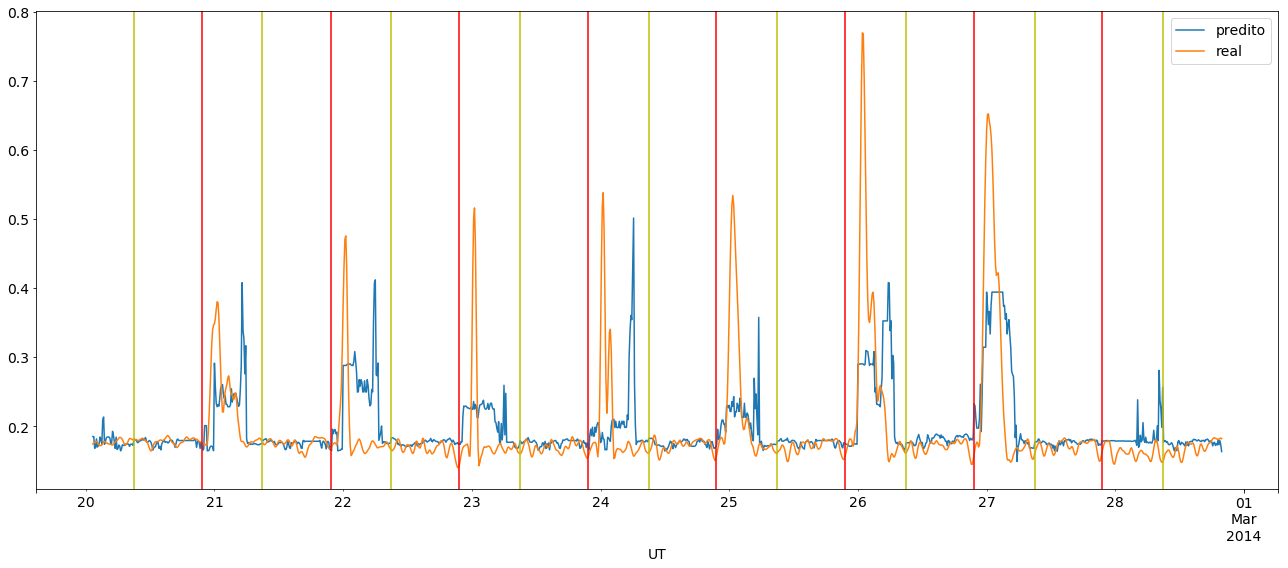

In [32]:
generate_and_avaliate_model(df, ['vtec',] + tempo + mdv2, 's4')

O erro quadrático médio foi: 0.000971
O erro quadrático total foi: 1.820339
O maior erro por previsão foi: 0.355290
O erro relativo foi: 6.023292%
O número de verdadeiros negativos foi: 2904
O número de verdadeiros positivos foi: 293
O número de falsos negativos foi: 82
O número de falsos positivos foi: 135
O POD foi: 0.781333
O FAR foi: 0.315421
A ACC foi: 0.936438
O kappa foi: 0.023824

Error for the time series sample:
O erro quadrático médio foi: 0.005092
O erro quadrático total foi: 2.536879
O maior erro por previsão foi: 0.471249
O erro relativo foi: 14.420497%
O número de verdadeiros negativos foi: 1005
O número de verdadeiros positivos foi: 98
O número de falsos negativos foi: 55
O número de falsos positivos foi: 106
O POD foi: 0.640523
O FAR foi: 0.519608
A ACC foi: 0.872627
O kappa foi: 0.041099


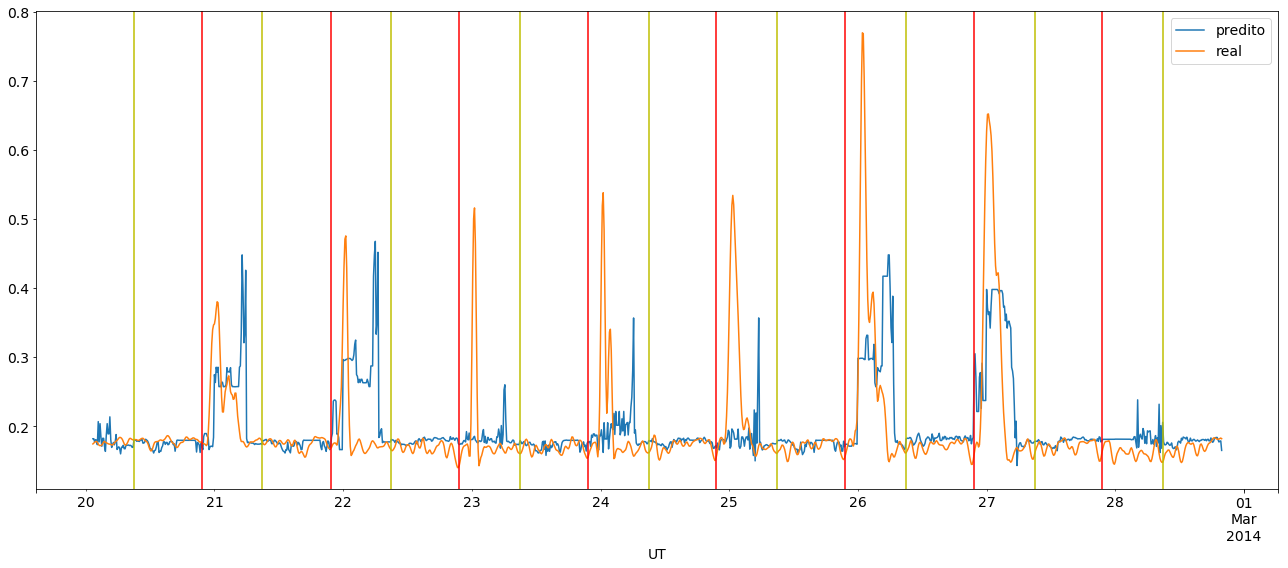

In [33]:
generate_and_avaliate_model(df, ['vtec',] + tempo + mdv1 + mdv2, 's4')

O erro quadrático médio foi: 0.001207
O erro quadrático total foi: 2.030189
O maior erro por previsão foi: 0.372488
O erro relativo foi: 8.027945%
O número de verdadeiros negativos foi: 2821
O número de verdadeiros positivos foi: 280
O número de falsos negativos foi: 95
O número de falsos positivos foi: 218
O POD foi: 0.746667
O FAR foi: 0.437751
A ACC foi: 0.908319
O kappa foi: 0.028230

Error for the time series sample:
O erro quadrático médio foi: 0.003708
O erro quadrático total foi: 2.164927
O maior erro por previsão foi: 0.443210
O erro relativo foi: 14.302398%
O número de verdadeiros negativos foi: 977
O número de verdadeiros positivos foi: 123
O número de falsos negativos foi: 30
O número de falsos positivos foi: 134
O POD foi: 0.803922
O FAR foi: 0.521401
A ACC foi: 0.870253
O kappa foi: 0.028661


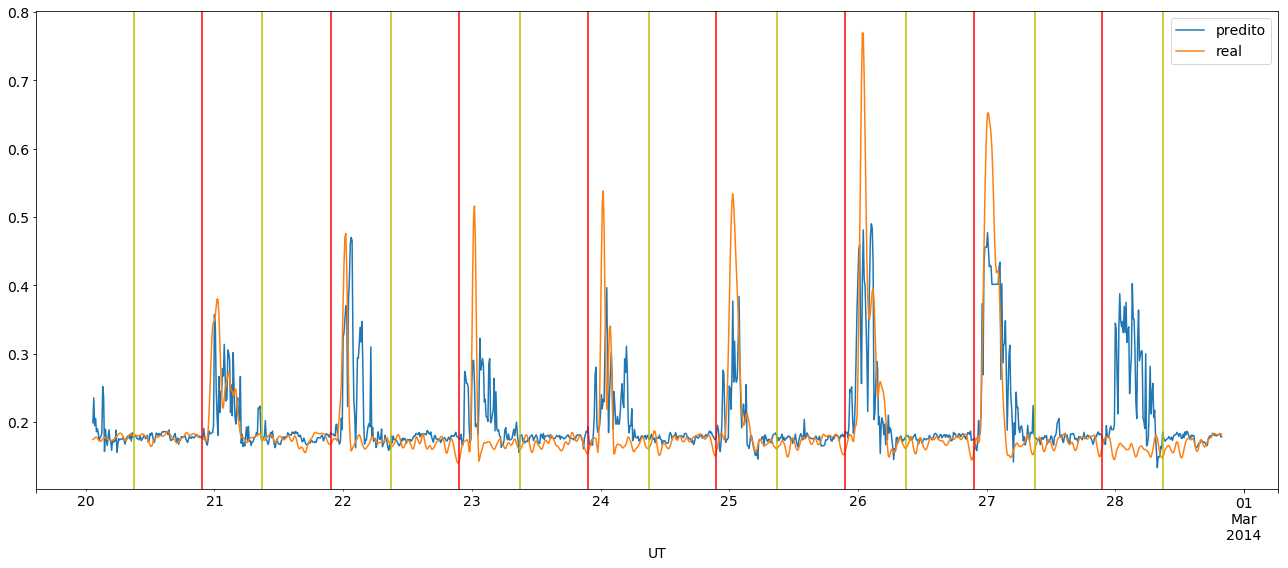

In [34]:
generate_and_avaliate_model(df, ['vtec',] + tempo + lag, 's4')

O erro quadrático médio foi: 0.000584
O erro quadrático total foi: 1.411661
O maior erro por previsão foi: 0.374209
O erro relativo foi: 5.180418%
O número de verdadeiros negativos foi: 2900
O número de verdadeiros positivos foi: 320
O número de falsos negativos foi: 55
O número de falsos positivos foi: 139
O POD foi: 0.853333
O FAR foi: 0.302832
A ACC foi: 0.943175
O kappa foi: 0.017501

Error for the time series sample:
O erro quadrático médio foi: 0.005216
O erro quadrático total foi: 2.567737
O maior erro por previsão foi: 0.583831
O erro relativo foi: 13.268431%
O número de verdadeiros negativos foi: 998
O número de verdadeiros positivos foi: 106
O número de falsos negativos foi: 47
O número de falsos positivos foi: 113
O POD foi: 0.692810
O FAR foi: 0.515982
A ACC foi: 0.873418
O kappa foi: 0.036856


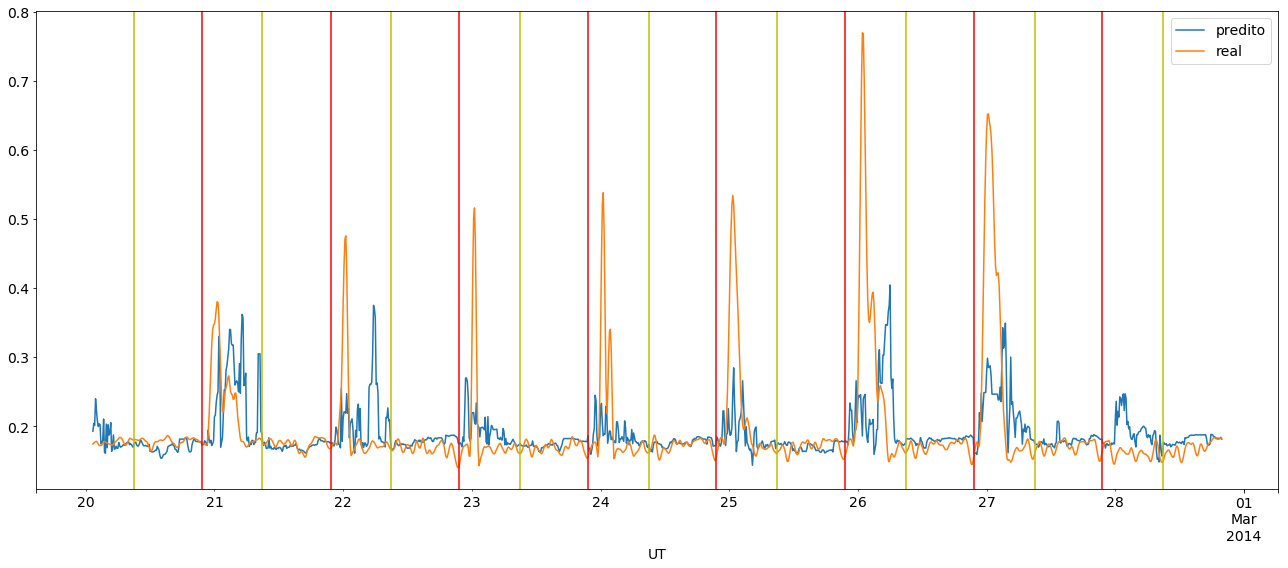

In [35]:
generate_and_avaliate_model(df, ['vtec',] + tempo + lag + mdv1, 's4')

O erro quadrático médio foi: 0.000563
O erro quadrático total foi: 1.386252
O maior erro por previsão foi: 0.367552
O erro relativo foi: 4.960397%
O número de verdadeiros negativos foi: 2907
O número de verdadeiros positivos foi: 321
O número de falsos negativos foi: 54
O número de falsos positivos foi: 132
O POD foi: 0.856000
O FAR foi: 0.291391
A ACC foi: 0.945518
O kappa foi: 0.017104

Error for the time series sample:
O erro quadrático médio foi: 0.004382
O erro quadrático total foi: 2.353581
O maior erro por previsão foi: 0.532826
O erro relativo foi: 13.066825%
O número de verdadeiros negativos foi: 965
O número de verdadeiros positivos foi: 127
O número de falsos negativos foi: 26
O número de falsos positivos foi: 146
O POD foi: 0.830065
O FAR foi: 0.534799
A ACC foi: 0.863924
O kappa foi: 0.027309


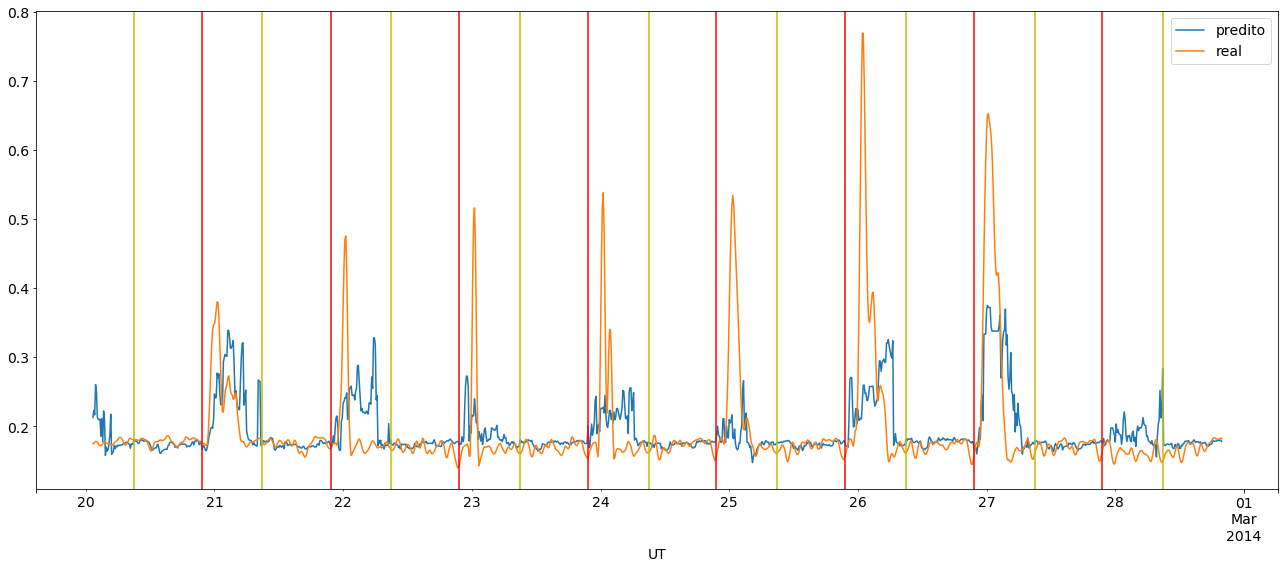

In [36]:
generate_and_avaliate_model(df, ['vtec',] + tempo + lag + mdv2, 's4')

O erro quadrático médio foi: 0.000536
O erro quadrático total foi: 1.352906
O maior erro por previsão foi: 0.350142
O erro relativo foi: 4.865205%
O número de verdadeiros negativos foi: 2912
O número de verdadeiros positivos foi: 335
O número de falsos negativos foi: 40
O número de falsos positivos foi: 127
O POD foi: 0.893333
O FAR foi: 0.274892
A ACC foi: 0.951084
O kappa foi: 0.013644

Error for the time series sample:
O erro quadrático médio foi: 0.004827
O erro quadrático total foi: 2.470211
O maior erro por previsão foi: 0.556560
O erro relativo foi: 13.415364%
O número de verdadeiros negativos foi: 965
O número de verdadeiros positivos foi: 119
O número de falsos negativos foi: 34
O número de falsos positivos foi: 146
O POD foi: 0.777778
O FAR foi: 0.550943
A ACC foi: 0.857595
O kappa foi: 0.031410


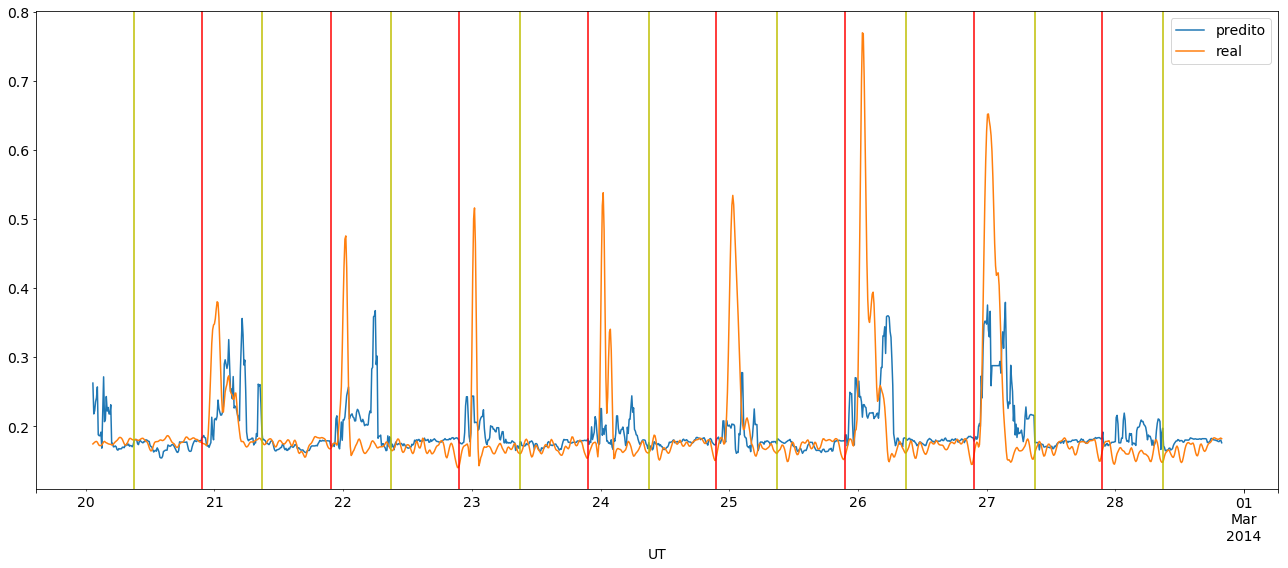

In [37]:
generate_and_avaliate_model(df, ['vtec',] + tempo + lag + mdv1 + mdv2, 's4')

O erro quadrático médio foi: 0.000599
O erro quadrático total foi: 1.430202
O maior erro por previsão foi: 0.249651
O erro relativo foi: 5.182108%
O número de verdadeiros negativos foi: 2905
O número de verdadeiros positivos foi: 327
O número de falsos negativos foi: 48
O número de falsos positivos foi: 134
O POD foi: 0.872000
O FAR foi: 0.290672
A ACC foi: 0.946690
O kappa foi: 0.015723

Error for the time series sample:
O erro quadrático médio foi: 0.003931
O erro quadrático total foi: 2.229209
O maior erro por previsão foi: 0.513966
O erro relativo foi: 13.197827%
O número de verdadeiros negativos foi: 928
O número de verdadeiros positivos foi: 130
O número de falsos negativos foi: 23
O número de falsos positivos foi: 183
O POD foi: 0.849673
O FAR foi: 0.584665
A ACC foi: 0.837025
O kappa foi: 0.028249


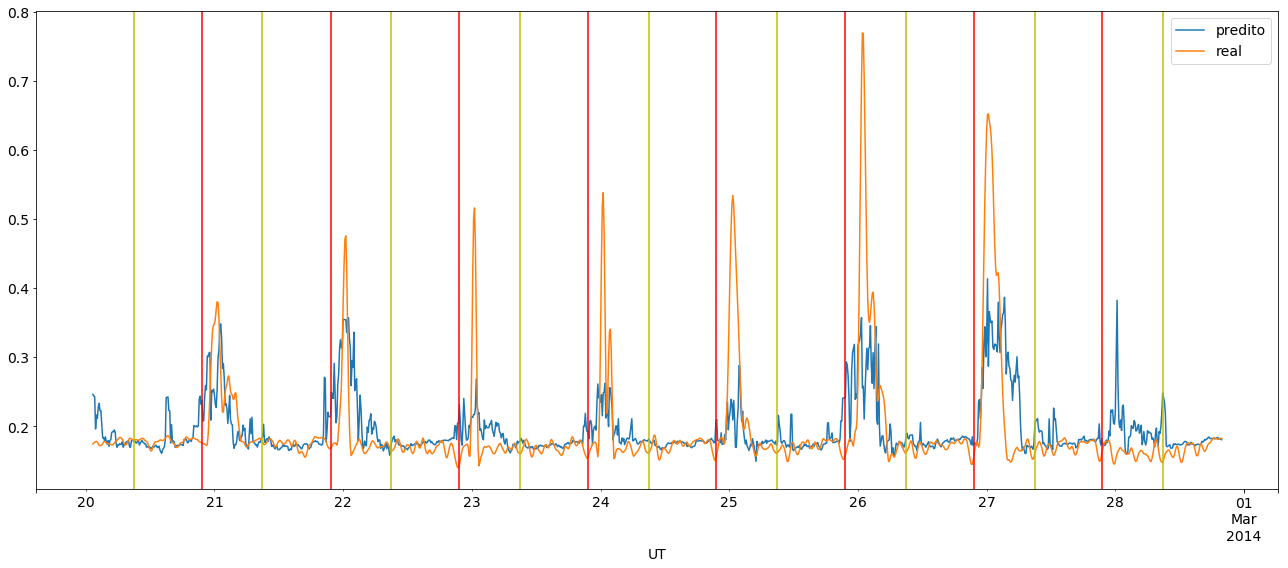

In [38]:
generate_and_avaliate_model(df, original + tempo + lag + mdv1 + mdv2, 's4')